In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset , ValidUnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.99,
    "weight_decay" : 3e-5,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"dice loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-DSV",
    "deep_super_vision" : True
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss",args["loss_type"]]
out_counts = 7 if args["deep_super_vision"] else 1
loss_weights = [1/(2**i) for i in range(out_counts)]
loss_weights

[1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625]

In [3]:
"""
torch.Size([10, 26, 512, 512])
torch.Size([10, 26, 256, 256])
torch.Size([10, 26, 128, 128])
torch.Size([10, 26, 64, 64])
torch.Size([10, 26, 32, 32])
torch.Size([10, 26, 16, 16])
torch.Size([10, 26, 8, 8])
"""
# model = nnUnet(args).to("cuda")
# ls = torch.ones((10,1,512,512)).float().to("cuda")
# with torch.autocast(device_type=args["device"],dtype=torch.float16):
#     outs =  model(ls)
#     for out in outs:
#         print(out.shape)

'\ntorch.Size([10, 26, 512, 512])\ntorch.Size([10, 26, 256, 256])\ntorch.Size([10, 26, 128, 128])\ntorch.Size([10, 26, 64, 64])\ntorch.Size([10, 26, 32, 32])\ntorch.Size([10, 26, 16, 16])\ntorch.Size([10, 26, 8, 8])\n'

In [4]:
# with open("./data/train_class_counts.json","r") as f:
#     train_class_counts = json.load(f)

# b = 0.999999

# counts = [0]*(len(train_class_counts))
# for k,v in train_class_counts.items():
#     counts[int(k)] = int(v)
# counts = np.array(counts,dtype=np.float64)

# f_alpha = (1-b)/(1-np.power(b,counts))
# f_alpha = f_alpha / f_alpha.sum()
# f_alpha[12] = 0.25
# # args["f_alpha"] = f_alpha.tolist()
# args["f_alpha"]=None
# args["f_alpha"]

In [5]:
b=0.999
train_class_counts = [
    1200,374,375,369,303,525,525,
    340,310,198,70,21,1,320,61,
    129,305,107,49,38,232,43,48,31,63,127
]
f_alpha = (1-b)/(1-np.power(b,train_class_counts))
print(f_alpha)

[0.00143064 0.00320357 0.00319653 0.00323937 0.0038239  0.00244738
 0.00244738 0.003468   0.00375    0.00556448 0.01478441 0.04809698
 1.         0.00365007 0.01689033 0.00825881 0.00380244 0.00985004
 0.02090204 0.0268058  0.00482751 0.02374777 0.02132692 0.03274452
 0.01637033 0.00838066]


In [6]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [7]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
    ]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None


In [8]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images,base_size=args["image_shape"][0],out_counts=out_counts)
valid_ds = ValidUnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [10]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     momentum=args["momentum"],
#     lr=args["lr"],
#     nesterov=True,
#     weight_decay=args["weight_decay"]
# )
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(
    args=args,
    recorder = recorder,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_loader = train_loader,
    valid_loader = valid_loader,
    loss_weights=loss_weights)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to dice


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.8409, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.011567
encoders.0.layers.0.layers.0.bias: 0.000000
encoders.0.layers.0.layers.1.weight: 0.003110
encoders.0.layers.0.layers.1.bias: 0.004711
encoders.0.layers.1.layers.0.weight: 0.056348
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.004880
encoders.0.layers.1.layers.1.bias: 0.004115
encoders.1.layers.0.layers.0.weight: 0.090856
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.005043
encoders.1.layers.0.layers.1.bias: 0.004709
encoders.1.layers.1.layers.0.weight: 0.072656
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.003819
encoders.1.layers.1.layers.1.bias: 0.003306
encoders.2.layers.0.layers.0.weight: 0.044704
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.002580
encoders.2.layers.0.layers.1.bias: 0.001970
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7660, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.028348
encoders.0.layers.0.layers.0.bias: 0.000001
encoders.0.layers.0.layers.1.weight: 0.003962
encoders.0.layers.0.layers.1.bias: 0.004904
encoders.0.layers.1.layers.0.weight: 0.072519
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.004011
encoders.0.layers.1.layers.1.bias: 0.004921
encoders.1.layers.0.layers.0.weight: 0.082043
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.005443
encoders.1.layers.0.layers.1.bias: 0.005766
encoders.1.layers.1.layers.0.weight: 0.097277
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.006742
encoders.1.layers.1.layers.1.bias: 0.006158
encoders.2.layers.0.layers.0.weight: 0.049928
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.003635
encoders.2.layers.0.layers.1.bias: 0.003621
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.2714, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.049509
encoders.0.layers.0.layers.0.bias: 0.000002
encoders.0.layers.0.layers.1.weight: 0.002897
encoders.0.layers.0.layers.1.bias: 0.003102
encoders.0.layers.1.layers.0.weight: 0.067461
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.003644
encoders.0.layers.1.layers.1.bias: 0.003081
encoders.1.layers.0.layers.0.weight: 0.065759
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.003311
encoders.1.layers.0.layers.1.bias: 0.002884
encoders.1.layers.1.layers.0.weight: 0.060584
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.004885
encoders.1.layers.1.layers.1.bias: 0.003464
encoders.2.layers.0.layers.0.weight: 0.040158
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.002919
encoders.2.layers.0.layers.1.bias: 0.001874
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3939, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.189103
encoders.0.layers.0.layers.0.bias: 0.000005
encoders.0.layers.0.layers.1.weight: 0.010005
encoders.0.layers.0.layers.1.bias: 0.006822
encoders.0.layers.1.layers.0.weight: 0.100992
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.006473
encoders.0.layers.1.layers.1.bias: 0.005676
encoders.1.layers.0.layers.0.weight: 0.096986
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.005529
encoders.1.layers.0.layers.1.bias: 0.004693
encoders.1.layers.1.layers.0.weight: 0.088401
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.006985
encoders.1.layers.1.layers.1.bias: 0.003414
encoders.2.layers.0.layers.0.weight: 0.079869
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.005391
encoders.2.layers.0.layers.1.bias: 0.003288
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5972, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.448979
encoders.0.layers.0.layers.0.bias: 0.000004
encoders.0.layers.0.layers.1.weight: 0.010748
encoders.0.layers.0.layers.1.bias: 0.011343
encoders.0.layers.1.layers.0.weight: 0.158356
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.009511
encoders.0.layers.1.layers.1.bias: 0.007500
encoders.1.layers.0.layers.0.weight: 0.109605
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.007621
encoders.1.layers.0.layers.1.bias: 0.005109
encoders.1.layers.1.layers.0.weight: 0.107325
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.007546
encoders.1.layers.1.layers.1.bias: 0.004516
encoders.2.layers.0.layers.0.weight: 0.087440
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.007089
encoders.2.layers.0.layers.1.bias: 0.003450
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : -0.017516187238506974 - CE loss : 0.2458190056681633 - dice loss : -0.26333519458770754

train avg metrics for epoch 5 :
avg dice : 0.17980071243146212 - avg precision : 0.20718232274055481 - avg recall : 0.1824975970509695
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : -0.004312527552247048 - CE loss : 0.138591081276536 - dice loss : -0.14290360882878303

valid avg metrics for epoch 5 :
avg dice : 0.1792871509674505 - avg precision : 0.21713024079799653 - avg recall : 0.1859095447645086
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3770, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.217599
encoders.0.layers.0.layers.0.bias: 0.000003
encoders.0.layers.0.layers.1.weight: 0.012232
encoders.0.layers.0.layers.1.bias: 0.005796
encoders.0.layers.1.layers.0.weight: 0.113439
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.011470
encoders.0.layers.1.layers.1.bias: 0.007674
encoders.1.layers.0.layers.0.weight: 0.085354
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.006666
encoders.1.layers.0.layers.1.bias: 0.003697
encoders.1.layers.1.layers.0.weight: 0.071759
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.008295
encoders.1.layers.1.layers.1.bias: 0.003685
encoders.2.layers.0.layers.0.weight: 0.062840
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.007212
encoders.2.layers.0.layers.1.bias: 0.003951
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8556, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.595668
encoders.0.layers.0.layers.0.bias: 0.000009
encoders.0.layers.0.layers.1.weight: 0.015903
encoders.0.layers.0.layers.1.bias: 0.010493
encoders.0.layers.1.layers.0.weight: 0.215748
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.018380
encoders.0.layers.1.layers.1.bias: 0.012846
encoders.1.layers.0.layers.0.weight: 0.160629
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.017422
encoders.1.layers.0.layers.1.bias: 0.013087
encoders.1.layers.1.layers.0.weight: 0.178896
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.017654
encoders.1.layers.1.layers.1.bias: 0.011042
encoders.2.layers.0.layers.0.weight: 0.130176
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.014467
encoders.2.layers.0.layers.1.bias: 0.008009
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6721, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.312445
encoders.0.layers.0.layers.0.bias: 0.000006
encoders.0.layers.0.layers.1.weight: 0.013610
encoders.0.layers.0.layers.1.bias: 0.014414
encoders.0.layers.1.layers.0.weight: 0.152103
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.017989
encoders.0.layers.1.layers.1.bias: 0.018551
encoders.1.layers.0.layers.0.weight: 0.159834
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.016122
encoders.1.layers.0.layers.1.bias: 0.016393
encoders.1.layers.1.layers.0.weight: 0.152998
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.019828
encoders.1.layers.1.layers.1.bias: 0.013685
encoders.2.layers.0.layers.0.weight: 0.129616
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.020272
encoders.2.layers.0.layers.1.bias: 0.009877
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.0464, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.747834
encoders.0.layers.0.layers.0.bias: 0.000007
encoders.0.layers.0.layers.1.weight: 0.021764
encoders.0.layers.0.layers.1.bias: 0.029567
encoders.0.layers.1.layers.0.weight: 0.195948
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.026131
encoders.0.layers.1.layers.1.bias: 0.019269
encoders.1.layers.0.layers.0.weight: 0.192063
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.020641
encoders.1.layers.0.layers.1.bias: 0.018652
encoders.1.layers.1.layers.0.weight: 0.177650
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.028005
encoders.1.layers.1.layers.1.bias: 0.017873
encoders.2.layers.0.layers.0.weight: 0.151316
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.021175
encoders.2.layers.0.layers.1.bias: 0.012538
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6581, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.433769
encoders.0.layers.0.layers.0.bias: 0.000004
encoders.0.layers.0.layers.1.weight: 0.016423
encoders.0.layers.0.layers.1.bias: 0.012023
encoders.0.layers.1.layers.0.weight: 0.142382
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.015331
encoders.0.layers.1.layers.1.bias: 0.016916
encoders.1.layers.0.layers.0.weight: 0.116358
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.011399
encoders.1.layers.0.layers.1.bias: 0.012465
encoders.1.layers.1.layers.0.weight: 0.086953
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.013967
encoders.1.layers.1.layers.1.bias: 0.009171
encoders.2.layers.0.layers.0.weight: 0.076523
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.013402
encoders.2.layers.0.layers.1.bias: 0.007485
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11)
total loss : -0.2597642379812896 - CE loss : 0.19638107299804688 - dice loss : -0.4561453075706959

train avg metrics for epoch 11 :
avg dice : 0.2792876377706071 - avg precision : 0.282034592628479 - avg recall : 0.2814693288132548
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : -0.1324409045279026 - CE loss : 0.1126148123294115 - dice loss : -0.24505571722984315

valid avg metrics for epoch 11 :
avg dice : 0.2837184777859461 - avg precision : 0.30353132903575897 - avg recall : 0.2758940750360489
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7958, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.528640
encoders.0.layers.0.layers.0.bias: 0.000007
encoders.0.layers.0.layers.1.weight: 0.023407
encoders.0.layers.0.layers.1.bias: 0.022029
encoders.0.layers.1.layers.0.weight: 0.189964
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.023658
encoders.0.layers.1.layers.1.bias: 0.017216
encoders.1.layers.0.layers.0.weight: 0.145569
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.018211
encoders.1.layers.0.layers.1.bias: 0.011457
encoders.1.layers.1.layers.0.weight: 0.099056
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.019122
encoders.1.layers.1.layers.1.bias: 0.011473
encoders.2.layers.0.layers.0.weight: 0.085813
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.015055
encoders.2.layers.0.layers.1.bias: 0.009419
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6043, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.379788
encoders.0.layers.0.layers.0.bias: 0.000005
encoders.0.layers.0.layers.1.weight: 0.008055
encoders.0.layers.0.layers.1.bias: 0.008333
encoders.0.layers.1.layers.0.weight: 0.086749
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.016165
encoders.0.layers.1.layers.1.bias: 0.010958
encoders.1.layers.0.layers.0.weight: 0.091547
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.008766
encoders.1.layers.0.layers.1.bias: 0.011798
encoders.1.layers.1.layers.0.weight: 0.082189
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.015908
encoders.1.layers.1.layers.1.bias: 0.006707
encoders.2.layers.0.layers.0.weight: 0.072998
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.011321
encoders.2.layers.0.layers.1.bias: 0.005551
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4661, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.342960
encoders.0.layers.0.layers.0.bias: 0.000008
encoders.0.layers.0.layers.1.weight: 0.007993
encoders.0.layers.0.layers.1.bias: 0.008566
encoders.0.layers.1.layers.0.weight: 0.066759
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.011406
encoders.0.layers.1.layers.1.bias: 0.006948
encoders.1.layers.0.layers.0.weight: 0.062445
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.006253
encoders.1.layers.0.layers.1.bias: 0.007306
encoders.1.layers.1.layers.0.weight: 0.058340
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.009721
encoders.1.layers.1.layers.1.bias: 0.005785
encoders.2.layers.0.layers.0.weight: 0.048278
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.006268
encoders.2.layers.0.layers.1.bias: 0.004128
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7239, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.543891
encoders.0.layers.0.layers.0.bias: 0.000009
encoders.0.layers.0.layers.1.weight: 0.013923
encoders.0.layers.0.layers.1.bias: 0.019818
encoders.0.layers.1.layers.0.weight: 0.158982
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.016764
encoders.0.layers.1.layers.1.bias: 0.024332
encoders.1.layers.0.layers.0.weight: 0.147351
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.012096
encoders.1.layers.0.layers.1.bias: 0.018892
encoders.1.layers.1.layers.0.weight: 0.106647
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.017858
encoders.1.layers.1.layers.1.bias: 0.015614
encoders.2.layers.0.layers.0.weight: 0.083266
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.013034
encoders.2.layers.0.layers.1.bias: 0.010824
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9570, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.738283
encoders.0.layers.0.layers.0.bias: 0.000008
encoders.0.layers.0.layers.1.weight: 0.017554
encoders.0.layers.0.layers.1.bias: 0.019477
encoders.0.layers.1.layers.0.weight: 0.132417
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.020623
encoders.0.layers.1.layers.1.bias: 0.020191
encoders.1.layers.0.layers.0.weight: 0.147848
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.015840
encoders.1.layers.0.layers.1.bias: 0.018050
encoders.1.layers.1.layers.0.weight: 0.108751
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.020135
encoders.1.layers.1.layers.1.bias: 0.013026
encoders.2.layers.0.layers.0.weight: 0.099501
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.020207
encoders.2.layers.0.layers.1.bias: 0.011355
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17)
total loss : -0.3774352312088013 - CE loss : 0.17567816093564034 - dice loss : -0.5531133875250817

train avg metrics for epoch 17 :
avg dice : 0.33608620999422845 - avg precision : 0.33607595294713977 - avg recall : 0.3449464419391006
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : -0.18886315822601318 - CE loss : 0.10299135446548462 - dice loss : -0.2918545134365559

valid avg metrics for epoch 17 :
avg dice : 0.3283724339215414 - avg precision : 0.3685313712060452 - avg recall : 0.32967964860610666
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5905, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.499992
encoders.0.layers.0.layers.0.bias: 0.000012
encoders.0.layers.0.layers.1.weight: 0.008463
encoders.0.layers.0.layers.1.bias: 0.015265
encoders.0.layers.1.layers.0.weight: 0.097084
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.015964
encoders.0.layers.1.layers.1.bias: 0.014703
encoders.1.layers.0.layers.0.weight: 0.095275
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.009911
encoders.1.layers.0.layers.1.bias: 0.010544
encoders.1.layers.1.layers.0.weight: 0.084840
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.013117
encoders.1.layers.1.layers.1.bias: 0.007455
encoders.2.layers.0.layers.0.weight: 0.066977
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.010104
encoders.2.layers.0.layers.1.bias: 0.007759
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6091, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.344238
encoders.0.layers.0.layers.0.bias: 0.000007
encoders.0.layers.0.layers.1.weight: 0.008098
encoders.0.layers.0.layers.1.bias: 0.012022
encoders.0.layers.1.layers.0.weight: 0.088425
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.014211
encoders.0.layers.1.layers.1.bias: 0.012683
encoders.1.layers.0.layers.0.weight: 0.098020
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.012164
encoders.1.layers.0.layers.1.bias: 0.010771
encoders.1.layers.1.layers.0.weight: 0.089531
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.014930
encoders.1.layers.1.layers.1.bias: 0.012721
encoders.2.layers.0.layers.0.weight: 0.090914
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.015968
encoders.2.layers.0.layers.1.bias: 0.008713
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5136, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.331905
encoders.0.layers.0.layers.0.bias: 0.000004
encoders.0.layers.0.layers.1.weight: 0.014031
encoders.0.layers.0.layers.1.bias: 0.008100
encoders.0.layers.1.layers.0.weight: 0.098814
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.015813
encoders.0.layers.1.layers.1.bias: 0.009282
encoders.1.layers.0.layers.0.weight: 0.087236
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.009629
encoders.1.layers.0.layers.1.bias: 0.008941
encoders.1.layers.1.layers.0.weight: 0.072250
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.009909
encoders.1.layers.1.layers.1.bias: 0.008047
encoders.2.layers.0.layers.0.weight: 0.059138
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.011343
encoders.2.layers.0.layers.1.bias: 0.008471
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21)
total loss : -0.4372086402773857 - CE loss : 0.16423485673964022 - dice loss : -0.6014434987306595

train avg metrics for epoch 21 :
avg dice : 0.36521866945125725 - avg precision : 0.36240617677569387 - avg recall : 0.374234603731893
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : -0.2130655474960804 - CE loss : 0.09552949368953705 - dice loss : -0.30859504267573357

valid avg metrics for epoch 21 :
avg dice : 0.34853222766591424 - avg precision : 0.3725241658464074 - avg recall : 0.35867176784930055
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5173, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.294239
encoders.0.layers.0.layers.0.bias: 0.000009
encoders.0.layers.0.layers.1.weight: 0.013584
encoders.0.layers.0.layers.1.bias: 0.009307
encoders.0.layers.1.layers.0.weight: 0.090196
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.019346
encoders.0.layers.1.layers.1.bias: 0.015907
encoders.1.layers.0.layers.0.weight: 0.099555
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.011221
encoders.1.layers.0.layers.1.bias: 0.012499
encoders.1.layers.1.layers.0.weight: 0.075271
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.015064
encoders.1.layers.1.layers.1.bias: 0.008132
encoders.2.layers.0.layers.0.weight: 0.062149
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.011865
encoders.2.layers.0.layers.1.bias: 0.007262
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5104, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.332798
encoders.0.layers.0.layers.0.bias: 0.000006
encoders.0.layers.0.layers.1.weight: 0.011007
encoders.0.layers.0.layers.1.bias: 0.007973
encoders.0.layers.1.layers.0.weight: 0.067626
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.012580
encoders.0.layers.1.layers.1.bias: 0.010300
encoders.1.layers.0.layers.0.weight: 0.073310
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.007235
encoders.1.layers.0.layers.1.bias: 0.007954
encoders.1.layers.1.layers.0.weight: 0.064719
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.011061
encoders.1.layers.1.layers.1.bias: 0.006001
encoders.2.layers.0.layers.0.weight: 0.056004
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.010337
encoders.2.layers.0.layers.1.bias: 0.007426
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5119, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.289252
encoders.0.layers.0.layers.0.bias: 0.000004
encoders.0.layers.0.layers.1.weight: 0.012788
encoders.0.layers.0.layers.1.bias: 0.010730
encoders.0.layers.1.layers.0.weight: 0.095645
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.017597
encoders.0.layers.1.layers.1.bias: 0.012361
encoders.1.layers.0.layers.0.weight: 0.124396
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.013980
encoders.1.layers.0.layers.1.bias: 0.016219
encoders.1.layers.1.layers.0.weight: 0.092272
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.018053
encoders.1.layers.1.layers.1.bias: 0.007731
encoders.2.layers.0.layers.0.weight: 0.090537
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.016972
encoders.2.layers.0.layers.1.bias: 0.010413
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25)
total loss : -0.43113411754369735 - CE loss : 0.16891208335757255 - dice loss : -0.6000462022423744

train avg metrics for epoch 25 :
avg dice : 0.37194910965899736 - avg precision : 0.37616244539618493 - avg recall : 0.38024271830916406
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : -0.21828284077346324 - CE loss : 0.09621584843844175 - dice loss : -0.31449869051575663

valid avg metrics for epoch 25 :
avg dice : 0.3600172161312914 - avg precision : 0.387873412668705 - avg recall : 0.3549387492984533
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9572, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.827263
encoders.0.layers.0.layers.0.bias: 0.000022
encoders.0.layers.0.layers.1.weight: 0.023107
encoders.0.layers.0.layers.1.bias: 0.024499
encoders.0.layers.1.layers.0.weight: 0.155469
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.028671
encoders.0.layers.1.layers.1.bias: 0.027555
encoders.1.layers.0.layers.0.weight: 0.168368
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.024904
encoders.1.layers.0.layers.1.bias: 0.024418
encoders.1.layers.1.layers.0.weight: 0.126370
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.024265
encoders.1.layers.1.layers.1.bias: 0.016224
encoders.2.layers.0.layers.0.weight: 0.100018
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.025023
encoders.2.layers.0.layers.1.bias: 0.015709
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27)
total loss : -0.47398982420563696 - CE loss : 0.16095804937183858 - dice loss : -0.6349478760361671

train avg metrics for epoch 27 :
avg dice : 0.3898957567293456 - avg precision : 0.39830446779727935 - avg recall : 0.3987455365434289
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : -0.2376711294054985 - CE loss : 0.09396053813397884 - dice loss : -0.33163166493177415

valid avg metrics for epoch 27 :
avg dice : 0.38395919881779617 - avg precision : 0.4082989563047886 - avg recall : 0.38782110238447787
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4257, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.246521
encoders.0.layers.0.layers.0.bias: 0.000013
encoders.0.layers.0.layers.1.weight: 0.009337
encoders.0.layers.0.layers.1.bias: 0.013275
encoders.0.layers.1.layers.0.weight: 0.060446
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.008417
encoders.0.layers.1.layers.1.bias: 0.009918
encoders.1.layers.0.layers.0.weight: 0.064277
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.008637
encoders.1.layers.0.layers.1.bias: 0.008817
encoders.1.layers.1.layers.0.weight: 0.056476
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.010282
encoders.1.layers.1.layers.1.bias: 0.005846
encoders.2.layers.0.layers.0.weight: 0.048663
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.008256
encoders.2.layers.0.layers.1.bias: 0.006224
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4270, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.141854
encoders.0.layers.0.layers.0.bias: 0.000006
encoders.0.layers.0.layers.1.weight: 0.010535
encoders.0.layers.0.layers.1.bias: 0.013055
encoders.0.layers.1.layers.0.weight: 0.068038
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.015479
encoders.0.layers.1.layers.1.bias: 0.019036
encoders.1.layers.0.layers.0.weight: 0.080974
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.008475
encoders.1.layers.0.layers.1.bias: 0.014012
encoders.1.layers.1.layers.0.weight: 0.069570
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.011809
encoders.1.layers.1.layers.1.bias: 0.008879
encoders.2.layers.0.layers.0.weight: 0.057651
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.011942
encoders.2.layers.0.layers.1.bias: 0.010121
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (30)
total loss : -0.49575037315487863 - CE loss : 0.15556733399629594 - dice loss : -0.6513177168369293

train avg metrics for epoch 30 :
avg dice : 0.4067236600075067 - avg precision : 0.4168100735545158 - avg recall : 0.4158499713614583
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (30)
total loss : -0.2403665639460087 - CE loss : 0.09306428376585245 - dice loss : -0.33343084454536437

valid avg metrics for epoch 30 :
avg dice : 0.38224321912984677 - avg precision : 0.4545769541431218 - avg recall : 0.3805007395008579
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.4412, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 1.356636
encoders.0.layers.0.layers.0.bias: 0.000023
encoders.0.layers.0.layers.1.weight: 0.035191
encoders.0.layers.0.layers.1.bias: 0.022714
encoders.0.layers.1.layers.0.weight: 0.214379
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.032765
encoders.0.layers.1.layers.1.bias: 0.022182
encoders.1.layers.0.layers.0.weight: 0.170828
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.021392
encoders.1.layers.0.layers.1.bias: 0.016431
encoders.1.layers.1.layers.0.weight: 0.139997
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.026581
encoders.1.layers.1.layers.1.bias: 0.013656
encoders.2.layers.0.layers.0.weight: 0.101494
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.022846
encoders.2.layers.0.layers.1.bias: 0.017401
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4106, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.182901
encoders.0.layers.0.layers.0.bias: 0.000005
encoders.0.layers.0.layers.1.weight: 0.007719
encoders.0.layers.0.layers.1.bias: 0.007211
encoders.0.layers.1.layers.0.weight: 0.046900
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.006632
encoders.0.layers.1.layers.1.bias: 0.007431
encoders.1.layers.0.layers.0.weight: 0.050292
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.005535
encoders.1.layers.0.layers.1.bias: 0.006432
encoders.1.layers.1.layers.0.weight: 0.047070
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.009491
encoders.1.layers.1.layers.1.bias: 0.004535
encoders.2.layers.0.layers.0.weight: 0.048161
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.012604
encoders.2.layers.0.layers.1.bias: 0.006308
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (33)
total loss : -0.5223180340230464 - CE loss : 0.1519671965390444 - dice loss : -0.6742852383852005

train avg metrics for epoch 33 :
avg dice : 0.43220315009392685 - avg precision : 0.4396294829249382 - avg recall : 0.43825505644083024
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (33)
total loss : -0.24825178757309913 - CE loss : 0.0917925301939249 - dice loss : -0.34004431664943696

valid avg metrics for epoch 33 :
avg dice : 0.3858941090853078 - avg precision : 0.41979348063468935 - avg recall : 0.3804330994002521
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (34)
total loss : -0.5414911937713623 - CE loss : 0.14885624304413794 - dice loss : -0.6903474277257919

train avg metrics for epoch 34 :
avg dice : 0.4389160376790896 - avg precision : 0.44462633490562437 - avg recall : 0.447439836114645
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (34)
total loss : -0.25027916580438614 - CE loss : 0.09183369018137455 - dice loss : -0.3421128585934639

valid avg metrics for epoch 34 :
avg dice : 0.4037905874104507 - avg precision : 0.42189554959535597 - avg recall : 0.4089970326051116
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.0052, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.695751
encoders.0.layers.0.layers.0.bias: 0.000021
encoders.0.layers.0.layers.1.weight: 0.031802
encoders.0.layers.0.layers.1.bias: 0.028204
encoders.0.layers.1.layers.0.weight: 0.197719
encoders.0.layers.1.layers.0.bias: 0.000003
encoders.0.layers.1.layers.1.weight: 0.035634
encoders.0.layers.1.layers.1.bias: 0.040745
encoders.1.layers.0.layers.0.weight: 0.294433
encoders.1.layers.0.layers.0.bias: 0.000003
encoders.1.layers.0.layers.1.weight: 0.048669
encoders.1.layers.0.layers.1.bias: 0.030221
encoders.1.layers.1.layers.0.weight: 0.247811
encoders.1.layers.1.layers.0.bias: 0.000002
encoders.1.layers.1.layers.1.weight: 0.051328
encoders.1.layers.1.layers.1.bias: 0.032297
encoders.2.layers.0.layers.0.weight: 0.243955
encoders.2.layers.0.layers.0.bias: 0.000001
encoders.2.layers.0.layers.1.weight: 0.052360
encoders.2.layers.0.layers.1.bias: 0.035763
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5321, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.164604
encoders.0.layers.0.layers.0.bias: 0.000008
encoders.0.layers.0.layers.1.weight: 0.006533
encoders.0.layers.0.layers.1.bias: 0.006546
encoders.0.layers.1.layers.0.weight: 0.052117
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.012146
encoders.0.layers.1.layers.1.bias: 0.008268
encoders.1.layers.0.layers.0.weight: 0.058185
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.008042
encoders.1.layers.0.layers.1.bias: 0.006236
encoders.1.layers.1.layers.0.weight: 0.051803
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.011444
encoders.1.layers.1.layers.1.bias: 0.006521
encoders.2.layers.0.layers.0.weight: 0.052229
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.011890
encoders.2.layers.0.layers.1.bias: 0.006562
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4129, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.224240
encoders.0.layers.0.layers.0.bias: 0.000015
encoders.0.layers.0.layers.1.weight: 0.012178
encoders.0.layers.0.layers.1.bias: 0.021306
encoders.0.layers.1.layers.0.weight: 0.089838
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.021516
encoders.0.layers.1.layers.1.bias: 0.021288
encoders.1.layers.0.layers.0.weight: 0.083229
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.010128
encoders.1.layers.0.layers.1.bias: 0.013266
encoders.1.layers.1.layers.0.weight: 0.059552
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.011480
encoders.1.layers.1.layers.1.bias: 0.007078
encoders.2.layers.0.layers.0.weight: 0.051173
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.010378
encoders.2.layers.0.layers.1.bias: 0.007859
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5547, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.433735
encoders.0.layers.0.layers.0.bias: 0.000007
encoders.0.layers.0.layers.1.weight: 0.014920
encoders.0.layers.0.layers.1.bias: 0.011637
encoders.0.layers.1.layers.0.weight: 0.090954
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.022419
encoders.0.layers.1.layers.1.bias: 0.016540
encoders.1.layers.0.layers.0.weight: 0.086198
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.016393
encoders.1.layers.0.layers.1.bias: 0.015929
encoders.1.layers.1.layers.0.weight: 0.072332
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.016094
encoders.1.layers.1.layers.1.bias: 0.010453
encoders.2.layers.0.layers.0.weight: 0.061370
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.012852
encoders.2.layers.0.layers.1.bias: 0.010095
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (39)
total loss : -0.5459547998011112 - CE loss : 0.1481283024698496 - dice loss : -0.6940831092000007

train avg metrics for epoch 39 :
avg dice : 0.45285478115118866 - avg precision : 0.4493172031641006 - avg recall : 0.46561249777674674
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (39)
total loss : -0.24464458040893078 - CE loss : 0.09606688097119331 - dice loss : -0.3407114647328854

valid avg metrics for epoch 39 :
avg dice : 0.3965671374649865 - avg precision : 0.43541220635175704 - avg recall : 0.3825404566153884
1 => dice : 0.7581735253334045 p : 0.7723065614700317 , r : 0.7445484399795532
2 => dice : 0.6814702153205872 p : 0.7330911159515381 , r : 0.6366408467292786
3 => dice : 0.6992985010147095 p : 0.6984468698501587 , r : 0.7001522183418274
4 => dice : 0.5413020253181458 p : 0.6646596193313599 , r : 0.4565657079219818
5 => dice : 0.752227783203125 p : 0.7248840928077698 , r : 0.7817152142524719
6 => dice : 0.6429288983345032 p

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4922, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.348391
encoders.0.layers.0.layers.0.bias: 0.000016
encoders.0.layers.0.layers.1.weight: 0.008701
encoders.0.layers.0.layers.1.bias: 0.012638
encoders.0.layers.1.layers.0.weight: 0.057776
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.019348
encoders.0.layers.1.layers.1.bias: 0.018420
encoders.1.layers.0.layers.0.weight: 0.069154
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.011212
encoders.1.layers.0.layers.1.bias: 0.014993
encoders.1.layers.1.layers.0.weight: 0.057683
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.013764
encoders.1.layers.1.layers.1.bias: 0.008666
encoders.2.layers.0.layers.0.weight: 0.054327
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.011406
encoders.2.layers.0.layers.1.bias: 0.007301
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (41)
total loss : -0.5402111060917377 - CE loss : 0.14876899145543576 - dice loss : -0.6889801025390625

train avg metrics for epoch 41 :
avg dice : 0.4535880964998138 - avg precision : 0.44779166638851164 - avg recall : 0.4659321877360344
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (41)
total loss : -0.232089601457119 - CE loss : 0.10148960910737514 - dice loss : -0.3335792116820812

valid avg metrics for epoch 41 :
avg dice : 0.3927276075632436 - avg precision : 0.41978573981672523 - avg recall : 0.381440059132874
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6066, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.498597
encoders.0.layers.0.layers.0.bias: 0.000008
encoders.0.layers.0.layers.1.weight: 0.013593
encoders.0.layers.0.layers.1.bias: 0.017477
encoders.0.layers.1.layers.0.weight: 0.087633
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.011374
encoders.0.layers.1.layers.1.bias: 0.017914
encoders.1.layers.0.layers.0.weight: 0.079755
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.010431
encoders.1.layers.0.layers.1.bias: 0.015775
encoders.1.layers.1.layers.0.weight: 0.061225
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.012260
encoders.1.layers.1.layers.1.bias: 0.007271
encoders.2.layers.0.layers.0.weight: 0.054672
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.010876
encoders.2.layers.0.layers.1.bias: 0.007658
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (43)
total loss : -0.563683218806982 - CE loss : 0.14601694576442242 - dice loss : -0.7097001576423645

train avg metrics for epoch 43 :
avg dice : 0.45565132439173583 - avg precision : 0.45108563840389254 - avg recall : 0.46847072303295134
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (43)
total loss : -0.2509813580662012 - CE loss : 0.09378088600933551 - dice loss : -0.3447622425854206

valid avg metrics for epoch 43 :
avg dice : 0.40669012166570256 - avg precision : 0.4378958649933338 - avg recall : 0.3923678571730852
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.1935, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.075718
encoders.0.layers.0.layers.0.bias: 0.000004
encoders.0.layers.0.layers.1.weight: 0.005491
encoders.0.layers.0.layers.1.bias: 0.003125
encoders.0.layers.1.layers.0.weight: 0.020750
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.005149
encoders.0.layers.1.layers.1.bias: 0.003508
encoders.1.layers.0.layers.0.weight: 0.026358
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.004096
encoders.1.layers.0.layers.1.bias: 0.004518
encoders.1.layers.1.layers.0.weight: 0.023104
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.005967
encoders.1.layers.1.layers.1.bias: 0.003855
encoders.2.layers.0.layers.0.weight: 0.021964
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.004906
encoders.2.layers.0.layers.1.bias: 0.003325
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8010, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.688862
encoders.0.layers.0.layers.0.bias: 0.000009
encoders.0.layers.0.layers.1.weight: 0.024579
encoders.0.layers.0.layers.1.bias: 0.018520
encoders.0.layers.1.layers.0.weight: 0.114380
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.025409
encoders.0.layers.1.layers.1.bias: 0.018089
encoders.1.layers.0.layers.0.weight: 0.093501
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.011984
encoders.1.layers.0.layers.1.bias: 0.011521
encoders.1.layers.1.layers.0.weight: 0.073664
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.015830
encoders.1.layers.1.layers.1.bias: 0.011277
encoders.2.layers.0.layers.0.weight: 0.067180
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.016825
encoders.2.layers.0.layers.1.bias: 0.011218
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (46)
total loss : -0.5827732589840889 - CE loss : 0.14272985987365247 - dice loss : -0.7255031287670135

train avg metrics for epoch 46 :
avg dice : 0.4750088489059341 - avg precision : 0.4687157863378525 - avg recall : 0.48909737199544906
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (46)
total loss : -0.22212142422795295 - CE loss : 0.10709376782178878 - dice loss : -0.3292151913046837

valid avg metrics for epoch 46 :
avg dice : 0.3846751647839778 - avg precision : 0.4213908115774393 - avg recall : 0.36439347146311774
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (47)
total loss : -0.5602783203125 - CE loss : 0.14882291048765184 - dice loss : -0.7091012302041054

train avg metrics for epoch 47 :
avg dice : 0.4645154142383454 - avg precision : 0.4574779826402664 - avg recall : 0.47821592569351196
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (47)
total loss : -0.2549553707242012 - CE loss : 0.09564898386597634 - dice loss : -0.35060435384511945

valid avg metrics for epoch 47 :
avg dice : 0.415442862808834 - avg precision : 0.43153262734413145 - avg recall : 0.41214900344610217
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4649, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.199695
encoders.0.layers.0.layers.0.bias: 0.000008
encoders.0.layers.0.layers.1.weight: 0.013829
encoders.0.layers.0.layers.1.bias: 0.009499
encoders.0.layers.1.layers.0.weight: 0.061258
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.010490
encoders.0.layers.1.layers.1.bias: 0.009192
encoders.1.layers.0.layers.0.weight: 0.065835
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.013461
encoders.1.layers.0.layers.1.bias: 0.013777
encoders.1.layers.1.layers.0.weight: 0.059257
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.015942
encoders.1.layers.1.layers.1.bias: 0.014849
encoders.2.layers.0.layers.0.weight: 0.057329
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.014522
encoders.2.layers.0.layers.1.bias: 0.011893
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3741, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.177199
encoders.0.layers.0.layers.0.bias: 0.000029
encoders.0.layers.0.layers.1.weight: 0.007720
encoders.0.layers.0.layers.1.bias: 0.006195
encoders.0.layers.1.layers.0.weight: 0.057840
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.012887
encoders.0.layers.1.layers.1.bias: 0.006891
encoders.1.layers.0.layers.0.weight: 0.063249
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.010395
encoders.1.layers.0.layers.1.bias: 0.006210
encoders.1.layers.1.layers.0.weight: 0.056196
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.011675
encoders.1.layers.1.layers.1.bias: 0.006485
encoders.2.layers.0.layers.0.weight: 0.052814
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.012388
encoders.2.layers.0.layers.1.bias: 0.009382
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8243, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.551913
encoders.0.layers.0.layers.0.bias: 0.000026
encoders.0.layers.0.layers.1.weight: 0.036230
encoders.0.layers.0.layers.1.bias: 0.040757
encoders.0.layers.1.layers.0.weight: 0.159301
encoders.0.layers.1.layers.0.bias: 0.000003
encoders.0.layers.1.layers.1.weight: 0.054892
encoders.0.layers.1.layers.1.bias: 0.062378
encoders.1.layers.0.layers.0.weight: 0.170558
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.024744
encoders.1.layers.0.layers.1.bias: 0.031794
encoders.1.layers.1.layers.0.weight: 0.143501
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.035389
encoders.1.layers.1.layers.1.bias: 0.025635
encoders.2.layers.0.layers.0.weight: 0.109060
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.025756
encoders.2.layers.0.layers.1.bias: 0.020628
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3605, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.127404
encoders.0.layers.0.layers.0.bias: 0.000006
encoders.0.layers.0.layers.1.weight: 0.008449
encoders.0.layers.0.layers.1.bias: 0.007127
encoders.0.layers.1.layers.0.weight: 0.041300
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.009723
encoders.0.layers.1.layers.1.bias: 0.006409
encoders.1.layers.0.layers.0.weight: 0.047887
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.006904
encoders.1.layers.0.layers.1.bias: 0.006896
encoders.1.layers.1.layers.0.weight: 0.042185
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.011080
encoders.1.layers.1.layers.1.bias: 0.004726
encoders.2.layers.0.layers.0.weight: 0.041953
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.010455
encoders.2.layers.0.layers.1.bias: 0.006840
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3596, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.217877
encoders.0.layers.0.layers.0.bias: 0.000007
encoders.0.layers.0.layers.1.weight: 0.007613
encoders.0.layers.0.layers.1.bias: 0.007754
encoders.0.layers.1.layers.0.weight: 0.039255
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.011378
encoders.0.layers.1.layers.1.bias: 0.009746
encoders.1.layers.0.layers.0.weight: 0.050926
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.007471
encoders.1.layers.0.layers.1.bias: 0.008397
encoders.1.layers.1.layers.0.weight: 0.041292
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.009208
encoders.1.layers.1.layers.1.bias: 0.005766
encoders.2.layers.0.layers.0.weight: 0.039751
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.011286
encoders.2.layers.0.layers.1.bias: 0.007329
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (53)
total loss : -0.6238767075538635 - CE loss : 0.13690985418856144 - dice loss : -0.7607865554094314

train avg metrics for epoch 53 :
avg dice : 0.5038349437717331 - avg precision : 0.4923122978210449 - avg recall : 0.5223433315753937
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (53)
total loss : -0.2683286350220442 - CE loss : 0.09200628772377968 - dice loss : -0.36033492013812063

valid avg metrics for epoch 53 :
avg dice : 0.4160330641364255 - avg precision : 0.43629233065992595 - avg recall : 0.41523705510422587
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (54)
total loss : -0.6285713669657708 - CE loss : 0.13708638310432433 - dice loss : -0.7656577563285828

train avg metrics for epoch 54 :
avg dice : 0.5024367904666789 - avg precision : 0.4914808851480484 - avg recall : 0.521378322839737
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (54)
total loss : -0.2593575090169907 - CE loss : 0.09409977048635483 - dice loss : -0.3534572795033455

valid avg metrics for epoch 54 :
avg dice : 0.42019861310731005 - avg precision : 0.46045384839177134 - avg recall : 0.40217628560960295
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (55)
total loss : -0.6188025161623955 - CE loss : 0.13781475834548473 - dice loss : -0.7566172790527343

train avg metrics for epoch 55 :
avg dice : 0.5005908590558892 - avg precision : 0.49154797434806824 - avg recall : 0.5164968925714493
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (55)
total loss : -0.2569973811507225 - CE loss : 0.0976379182189703 - dice loss : -0.3546352989971638

valid avg metrics for epoch 55 :
avg dice : 0.41286451756967807 - avg precision : 0.4292070326209068 - avg recall : 0.40983872264623644
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (56)
total loss : -0.6309935992956162 - CE loss : 0.13708498194813729 - dice loss : -0.768078585267067

train avg metrics for epoch 56 :
avg dice : 0.507856630683316 - avg precision : 0.49772284865379335 - avg recall : 0.5243064230680465
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (56)
total loss : -0.2497794795781374 - CE loss : 0.1007493283599615 - dice loss : -0.35052881091833116

valid avg metrics for epoch 56 :
avg dice : 0.406950456416389 - avg precision : 0.4303076493181288 - avg recall : 0.39948924087919296
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4551, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.316482
encoders.0.layers.0.layers.0.bias: 0.000013
encoders.0.layers.0.layers.1.weight: 0.011918
encoders.0.layers.0.layers.1.bias: 0.019261
encoders.0.layers.1.layers.0.weight: 0.090588
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.021401
encoders.0.layers.1.layers.1.bias: 0.020239
encoders.1.layers.0.layers.0.weight: 0.076463
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.012553
encoders.1.layers.0.layers.1.bias: 0.018071
encoders.1.layers.1.layers.0.weight: 0.066567
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.015330
encoders.1.layers.1.layers.1.bias: 0.013154
encoders.2.layers.0.layers.0.weight: 0.057194
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.014301
encoders.2.layers.0.layers.1.bias: 0.013238
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7700, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.619643
encoders.0.layers.0.layers.0.bias: 0.000020
encoders.0.layers.0.layers.1.weight: 0.015927
encoders.0.layers.0.layers.1.bias: 0.020135
encoders.0.layers.1.layers.0.weight: 0.098681
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.041636
encoders.0.layers.1.layers.1.bias: 0.038561
encoders.1.layers.0.layers.0.weight: 0.118908
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.020592
encoders.1.layers.0.layers.1.bias: 0.026594
encoders.1.layers.1.layers.0.weight: 0.097574
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.035419
encoders.1.layers.1.layers.1.bias: 0.025422
encoders.2.layers.0.layers.0.weight: 0.094467
encoders.2.layers.0.layers.0.bias: 0.000001
encoders.2.layers.0.layers.1.weight: 0.031813
encoders.2.layers.0.layers.1.bias: 0.019951
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4683, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.362846
encoders.0.layers.0.layers.0.bias: 0.000009
encoders.0.layers.0.layers.1.weight: 0.021492
encoders.0.layers.0.layers.1.bias: 0.019618
encoders.0.layers.1.layers.0.weight: 0.074577
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.025056
encoders.0.layers.1.layers.1.bias: 0.016881
encoders.1.layers.0.layers.0.weight: 0.083096
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.016632
encoders.1.layers.0.layers.1.bias: 0.019800
encoders.1.layers.1.layers.0.weight: 0.073679
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.020750
encoders.1.layers.1.layers.1.bias: 0.012669
encoders.2.layers.0.layers.0.weight: 0.067245
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.021277
encoders.2.layers.0.layers.1.bias: 0.013684
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7576, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.613713
encoders.0.layers.0.layers.0.bias: 0.000013
encoders.0.layers.0.layers.1.weight: 0.016740
encoders.0.layers.0.layers.1.bias: 0.026870
encoders.0.layers.1.layers.0.weight: 0.082545
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.024508
encoders.0.layers.1.layers.1.bias: 0.019325
encoders.1.layers.0.layers.0.weight: 0.088254
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.015381
encoders.1.layers.0.layers.1.bias: 0.019877
encoders.1.layers.1.layers.0.weight: 0.081363
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.018472
encoders.1.layers.1.layers.1.bias: 0.011592
encoders.2.layers.0.layers.0.weight: 0.063259
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.017011
encoders.2.layers.0.layers.1.bias: 0.011881
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (61)
total loss : -0.6352414909005165 - CE loss : 0.1349284380674362 - dice loss : -0.770169934630394

train avg metrics for epoch 61 :
avg dice : 0.5164658141139863 - avg precision : 0.5053835809230804 - avg recall : 0.5359242796897888
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (61)
total loss : -0.2554636407643557 - CE loss : 0.10039692632853985 - dice loss : -0.35586056411266326

valid avg metrics for epoch 61 :
avg dice : 0.4182263354585631 - avg precision : 0.456632376788184 - avg recall : 0.3962236226722598
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (62)
total loss : -0.6448319047689438 - CE loss : 0.1362877909094095 - dice loss : -0.7811196932196617

train avg metrics for epoch 62 :
avg dice : 0.5208604252342119 - avg precision : 0.51050308406353 - avg recall : 0.538496390581131
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (62)
total loss : -0.26066629961133003 - CE loss : 0.09703385606408119 - dice loss : -0.3577001549303532

valid avg metrics for epoch 62 :
avg dice : 0.41732263833297367 - avg precision : 0.43751512199640274 - avg recall : 0.41759177401661873
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6248, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.414449
encoders.0.layers.0.layers.0.bias: 0.000009
encoders.0.layers.0.layers.1.weight: 0.009268
encoders.0.layers.0.layers.1.bias: 0.009590
encoders.0.layers.1.layers.0.weight: 0.061619
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.022921
encoders.0.layers.1.layers.1.bias: 0.017619
encoders.1.layers.0.layers.0.weight: 0.066875
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.009452
encoders.1.layers.0.layers.1.bias: 0.014499
encoders.1.layers.1.layers.0.weight: 0.061109
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.018624
encoders.1.layers.1.layers.1.bias: 0.012701
encoders.2.layers.0.layers.0.weight: 0.067169
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.020898
encoders.2.layers.0.layers.1.bias: 0.012066
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (64)
total loss : -0.6395310825109481 - CE loss : 0.13747475989162922 - dice loss : -0.7770058426260948

train avg metrics for epoch 64 :
avg dice : 0.5143396288160212 - avg precision : 0.5063527828454971 - avg recall : 0.5282616478204727
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (64)
total loss : -0.24499830268323422 - CE loss : 0.1007332257926464 - dice loss : -0.34573152512311933

valid avg metrics for epoch 64 :
avg dice : 0.40157704465101784 - avg precision : 0.41231885097920895 - avg recall : 0.40596453107893465
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5565, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.481817
encoders.0.layers.0.layers.0.bias: 0.000012
encoders.0.layers.0.layers.1.weight: 0.014679
encoders.0.layers.0.layers.1.bias: 0.011826
encoders.0.layers.1.layers.0.weight: 0.071365
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.014286
encoders.0.layers.1.layers.1.bias: 0.010771
encoders.1.layers.0.layers.0.weight: 0.065549
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.011252
encoders.1.layers.0.layers.1.bias: 0.013886
encoders.1.layers.1.layers.0.weight: 0.059072
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.014681
encoders.1.layers.1.layers.1.bias: 0.008808
encoders.2.layers.0.layers.0.weight: 0.051314
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.012757
encoders.2.layers.0.layers.1.bias: 0.008097
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (66)
total loss : -0.6877508580684661 - CE loss : 0.12666875548660755 - dice loss : -0.8144196182489395

train avg metrics for epoch 66 :
avg dice : 0.5409672057632339 - avg precision : 0.5307139217853546 - avg recall : 0.5581059908866882
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (66)
total loss : -0.2747260522097349 - CE loss : 0.09674120806157589 - dice loss : -0.37146725729107855

valid avg metrics for epoch 66 :
avg dice : 0.43640279173866475 - avg precision : 0.4489200150966644 - avg recall : 0.43230480313301084
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4179, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.265379
encoders.0.layers.0.layers.0.bias: 0.000007
encoders.0.layers.0.layers.1.weight: 0.012845
encoders.0.layers.0.layers.1.bias: 0.017909
encoders.0.layers.1.layers.0.weight: 0.066148
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.019203
encoders.0.layers.1.layers.1.bias: 0.012624
encoders.1.layers.0.layers.0.weight: 0.079271
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.013473
encoders.1.layers.0.layers.1.bias: 0.010332
encoders.1.layers.1.layers.0.weight: 0.059946
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.017898
encoders.1.layers.1.layers.1.bias: 0.010099
encoders.2.layers.0.layers.0.weight: 0.057646
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.016349
encoders.2.layers.0.layers.1.bias: 0.011101
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5998, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.486980
encoders.0.layers.0.layers.0.bias: 0.000007
encoders.0.layers.0.layers.1.weight: 0.020105
encoders.0.layers.0.layers.1.bias: 0.016964
encoders.0.layers.1.layers.0.weight: 0.084287
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.023628
encoders.0.layers.1.layers.1.bias: 0.020810
encoders.1.layers.0.layers.0.weight: 0.083151
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.019537
encoders.1.layers.0.layers.1.bias: 0.019682
encoders.1.layers.1.layers.0.weight: 0.078112
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.022850
encoders.1.layers.1.layers.1.bias: 0.019213
encoders.2.layers.0.layers.0.weight: 0.075868
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.020043
encoders.2.layers.0.layers.1.bias: 0.013895
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9179, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.815884
encoders.0.layers.0.layers.0.bias: 0.000008
encoders.0.layers.0.layers.1.weight: 0.014488
encoders.0.layers.0.layers.1.bias: 0.017294
encoders.0.layers.1.layers.0.weight: 0.071731
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.012459
encoders.0.layers.1.layers.1.bias: 0.015576
encoders.1.layers.0.layers.0.weight: 0.073457
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.011895
encoders.1.layers.0.layers.1.bias: 0.018324
encoders.1.layers.1.layers.0.weight: 0.061971
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.019291
encoders.1.layers.1.layers.1.bias: 0.012619
encoders.2.layers.0.layers.0.weight: 0.059645
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.016511
encoders.2.layers.0.layers.1.bias: 0.011186
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3778, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.241275
encoders.0.layers.0.layers.0.bias: 0.000010
encoders.0.layers.0.layers.1.weight: 0.012283
encoders.0.layers.0.layers.1.bias: 0.011542
encoders.0.layers.1.layers.0.weight: 0.052532
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.012753
encoders.0.layers.1.layers.1.bias: 0.011979
encoders.1.layers.0.layers.0.weight: 0.057242
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.010240
encoders.1.layers.0.layers.1.bias: 0.013753
encoders.1.layers.1.layers.0.weight: 0.054087
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.017431
encoders.1.layers.1.layers.1.bias: 0.010664
encoders.2.layers.0.layers.0.weight: 0.054108
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.017908
encoders.2.layers.0.layers.1.bias: 0.014123
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (71)
total loss : -0.6740247881412507 - CE loss : 0.1310059481859207 - dice loss : -0.80503073990345

train avg metrics for epoch 71 :
avg dice : 0.5394067966941727 - avg precision : 0.5261126351356507 - avg recall : 0.5618723773956299
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (71)
total loss : -0.22430382221937178 - CE loss : 0.11127331368625164 - dice loss : -0.33557713478803636

valid avg metrics for epoch 71 :
avg dice : 0.39904860496533145 - avg precision : 0.4396459609270096 - avg recall : 0.387703450024128
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7085, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.506334
encoders.0.layers.0.layers.0.bias: 0.000010
encoders.0.layers.0.layers.1.weight: 0.015720
encoders.0.layers.0.layers.1.bias: 0.024028
encoders.0.layers.1.layers.0.weight: 0.083102
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.022062
encoders.0.layers.1.layers.1.bias: 0.029288
encoders.1.layers.0.layers.0.weight: 0.087282
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.022015
encoders.1.layers.0.layers.1.bias: 0.024642
encoders.1.layers.1.layers.0.weight: 0.071341
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.025389
encoders.1.layers.1.layers.1.bias: 0.015357
encoders.2.layers.0.layers.0.weight: 0.070508
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.019795
encoders.2.layers.0.layers.1.bias: 0.014802
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (73)
total loss : -0.6891874295473098 - CE loss : 0.1253337812423706 - dice loss : -0.814521211385727

train avg metrics for epoch 73 :
avg dice : 0.5602056372169383 - avg precision : 0.5466660416126251 - avg recall : 0.5811887466907502
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (73)
total loss : -0.26310411691665647 - CE loss : 0.10032381340861321 - dice loss : -0.3634279303252697

valid avg metrics for epoch 73 :
avg dice : 0.42157974377285073 - avg precision : 0.4359538677148521 - avg recall : 0.42931022733449936
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5521, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.414600
encoders.0.layers.0.layers.0.bias: 0.000043
encoders.0.layers.0.layers.1.weight: 0.013351
encoders.0.layers.0.layers.1.bias: 0.010216
encoders.0.layers.1.layers.0.weight: 0.066323
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.022870
encoders.0.layers.1.layers.1.bias: 0.018503
encoders.1.layers.0.layers.0.weight: 0.071273
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.015844
encoders.1.layers.0.layers.1.bias: 0.020676
encoders.1.layers.1.layers.0.weight: 0.056504
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.015412
encoders.1.layers.1.layers.1.bias: 0.011289
encoders.2.layers.0.layers.0.weight: 0.057975
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.017632
encoders.2.layers.0.layers.1.bias: 0.011745
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (75)
total loss : -0.7049500986933708 - CE loss : 0.12410025112330914 - dice loss : -0.829050343632698

train avg metrics for epoch 75 :
avg dice : 0.5617667913440604 - avg precision : 0.545290766954422 - avg recall : 0.5882603228092194
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (75)
total loss : -0.262484597787261 - CE loss : 0.10027650594711304 - dice loss : -0.36276110261678696

valid avg metrics for epoch 75 :
avg dice : 0.4257484512032134 - avg precision : 0.442347881346941 - avg recall : 0.43460676752030847
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5070, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.378647
encoders.0.layers.0.layers.0.bias: 0.000006
encoders.0.layers.0.layers.1.weight: 0.014323
encoders.0.layers.0.layers.1.bias: 0.014553
encoders.0.layers.1.layers.0.weight: 0.054165
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.018850
encoders.0.layers.1.layers.1.bias: 0.014801
encoders.1.layers.0.layers.0.weight: 0.064651
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.013390
encoders.1.layers.0.layers.1.bias: 0.014748
encoders.1.layers.1.layers.0.weight: 0.060095
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.015277
encoders.1.layers.1.layers.1.bias: 0.008999
encoders.2.layers.0.layers.0.weight: 0.063152
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.021029
encoders.2.layers.0.layers.1.bias: 0.013556
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4932, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.329332
encoders.0.layers.0.layers.0.bias: 0.000010
encoders.0.layers.0.layers.1.weight: 0.008579
encoders.0.layers.0.layers.1.bias: 0.008419
encoders.0.layers.1.layers.0.weight: 0.067165
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.014401
encoders.0.layers.1.layers.1.bias: 0.019014
encoders.1.layers.0.layers.0.weight: 0.064832
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.010752
encoders.1.layers.0.layers.1.bias: 0.014124
encoders.1.layers.1.layers.0.weight: 0.052239
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.014955
encoders.1.layers.1.layers.1.bias: 0.010485
encoders.2.layers.0.layers.0.weight: 0.056110
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.017223
encoders.2.layers.0.layers.1.bias: 0.015342
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (78)
total loss : -0.7086161386966705 - CE loss : 0.12715637162327767 - dice loss : -0.8357725071907044

train avg metrics for epoch 78 :
avg dice : 0.5623210716251266 - avg precision : 0.5491662561893463 - avg recall : 0.5831916451454162
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (78)
total loss : -0.2767588969320059 - CE loss : 0.09817822556942701 - dice loss : -0.37493712455034256

valid avg metrics for epoch 78 :
avg dice : 0.43984275594364236 - avg precision : 0.451745912656188 - avg recall : 0.4397048558294773
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4408, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.319204
encoders.0.layers.0.layers.0.bias: 0.000008
encoders.0.layers.0.layers.1.weight: 0.009202
encoders.0.layers.0.layers.1.bias: 0.011251
encoders.0.layers.1.layers.0.weight: 0.048182
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.014928
encoders.0.layers.1.layers.1.bias: 0.012727
encoders.1.layers.0.layers.0.weight: 0.058459
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.011837
encoders.1.layers.0.layers.1.bias: 0.013868
encoders.1.layers.1.layers.0.weight: 0.048337
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.014696
encoders.1.layers.1.layers.1.bias: 0.010793
encoders.2.layers.0.layers.0.weight: 0.052690
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.017319
encoders.2.layers.0.layers.1.bias: 0.013084
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5349, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.435377
encoders.0.layers.0.layers.0.bias: 0.000009
encoders.0.layers.0.layers.1.weight: 0.017018
encoders.0.layers.0.layers.1.bias: 0.014159
encoders.0.layers.1.layers.0.weight: 0.059265
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.014690
encoders.0.layers.1.layers.1.bias: 0.013721
encoders.1.layers.0.layers.0.weight: 0.064181
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.011709
encoders.1.layers.0.layers.1.bias: 0.014646
encoders.1.layers.1.layers.0.weight: 0.053798
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.018908
encoders.1.layers.1.layers.1.bias: 0.014237
encoders.2.layers.0.layers.0.weight: 0.055164
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.015949
encoders.2.layers.0.layers.1.bias: 0.011900
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (81)
total loss : -0.7212783724069596 - CE loss : 0.12050284899771213 - dice loss : -0.8417812275886536

train avg metrics for epoch 81 :
avg dice : 0.5834814703468215 - avg precision : 0.5705351114273072 - avg recall : 0.6036165082454681
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (81)
total loss : -0.26698155552148817 - CE loss : 0.1019859042018652 - dice loss : -0.36896745562553407

valid avg metrics for epoch 81 :
avg dice : 0.43193323746334145 - avg precision : 0.4530153229832649 - avg recall : 0.4280107706785202
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (82)
total loss : -0.7291846555471421 - CE loss : 0.1196566005051136 - dice loss : -0.8488412600755691

train avg metrics for epoch 82 :
avg dice : 0.5872939872745406 - avg precision : 0.5737529563903808 - avg recall : 0.6067257559299469
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (82)
total loss : -0.26847864016890527 - CE loss : 0.09705528505146503 - dice loss : -0.36553392112255095

valid avg metrics for epoch 82 :
avg dice : 0.43243447721015044 - avg precision : 0.4739795571565628 - avg recall : 0.4145444482564926
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (83)
total loss : -0.7355226409435273 - CE loss : 0.120481136739254 - dice loss : -0.8560037726163864

train avg metrics for epoch 83 :
avg dice : 0.5823719620708359 - avg precision : 0.5679388260841369 - avg recall : 0.6043512523174286
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (83)
total loss : -0.2601297065615654 - CE loss : 0.10749604552984238 - dice loss : -0.3676257498562336

valid avg metrics for epoch 83 :
avg dice : 0.42927085995684694 - avg precision : 0.45172138154506686 - avg recall : 0.42929914116859436
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.2927, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.199257
encoders.0.layers.0.layers.0.bias: 0.000004
encoders.0.layers.0.layers.1.weight: 0.005234
encoders.0.layers.0.layers.1.bias: 0.004919
encoders.0.layers.1.layers.0.weight: 0.027455
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.009804
encoders.0.layers.1.layers.1.bias: 0.006755
encoders.1.layers.0.layers.0.weight: 0.037322
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.006328
encoders.1.layers.0.layers.1.bias: 0.006280
encoders.1.layers.1.layers.0.weight: 0.032201
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.009356
encoders.1.layers.1.layers.1.bias: 0.005703
encoders.2.layers.0.layers.0.weight: 0.036553
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.009986
encoders.2.layers.0.layers.1.bias: 0.006785
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3626, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.239212
encoders.0.layers.0.layers.0.bias: 0.000007
encoders.0.layers.0.layers.1.weight: 0.011258
encoders.0.layers.0.layers.1.bias: 0.009089
encoders.0.layers.1.layers.0.weight: 0.037949
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.014256
encoders.0.layers.1.layers.1.bias: 0.015642
encoders.1.layers.0.layers.0.weight: 0.051543
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.011372
encoders.1.layers.0.layers.1.bias: 0.013848
encoders.1.layers.1.layers.0.weight: 0.044688
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.015558
encoders.1.layers.1.layers.1.bias: 0.010424
encoders.2.layers.0.layers.0.weight: 0.049365
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.015282
encoders.2.layers.0.layers.1.bias: 0.012556
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (86)
total loss : -0.7150239574909211 - CE loss : 0.12377185329794883 - dice loss : -0.8387958002090454

train avg metrics for epoch 86 :
avg dice : 0.5800394904617202 - avg precision : 0.5666346144676209 - avg recall : 0.5988321805000305
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (86)
total loss : -0.2732025422155857 - CE loss : 0.10022326447069645 - dice loss : -0.3734258055686951

valid avg metrics for epoch 86 :
avg dice : 0.43823845133195943 - avg precision : 0.4615097358636558 - avg recall : 0.4265874236822128
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (87)
total loss : -0.736510438323021 - CE loss : 0.12181531727313995 - dice loss : -0.8583257555961609

train avg metrics for epoch 87 :
avg dice : 0.5806724405292404 - avg precision : 0.5685232603549957 - avg recall : 0.5987248897552491
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (87)
total loss : -0.2686182364821434 - CE loss : 0.10133509933948517 - dice loss : -0.3699533365666866

valid avg metrics for epoch 87 :
avg dice : 0.4359731364251239 - avg precision : 0.4596048709005117 - avg recall : 0.43887066453695295
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5411, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.413553
encoders.0.layers.0.layers.0.bias: 0.000007
encoders.0.layers.0.layers.1.weight: 0.015717
encoders.0.layers.0.layers.1.bias: 0.009734
encoders.0.layers.1.layers.0.weight: 0.068807
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.024340
encoders.0.layers.1.layers.1.bias: 0.016813
encoders.1.layers.0.layers.0.weight: 0.073189
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.019545
encoders.1.layers.0.layers.1.bias: 0.022578
encoders.1.layers.1.layers.0.weight: 0.060212
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.021192
encoders.1.layers.1.layers.1.bias: 0.014530
encoders.2.layers.0.layers.0.weight: 0.060521
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.021243
encoders.2.layers.0.layers.1.bias: 0.017854
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (89)
total loss : -0.7351938110589981 - CE loss : 0.11840986855328083 - dice loss : -0.8536036768555642

train avg metrics for epoch 89 :
avg dice : 0.59531860113181 - avg precision : 0.5843110597133636 - avg recall : 0.6116902649402618
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (89)
total loss : -0.27929478622972964 - CE loss : 0.09832397773861885 - dice loss : -0.37761876583099363

valid avg metrics for epoch 89 :
avg dice : 0.4448460003734691 - avg precision : 0.47141018353402614 - avg recall : 0.43397126212716103
1 => dice : 0.8001957535743713 p : 0.8259825706481934 , r : 0.7759703397750854
2 => dice : 0.7369431853294373 p : 0.7653833031654358 , r : 0.7105409502983093
3 => dice : 0.7542516589164734 p : 0.7452982068061829 , r : 0.7634228467941284
4 => dice : 0.7157299518585205 p : 0.716816782951355 , r : 0.7146464586257935
5 => dice : 0.7745321989059448 p : 0.8487250804901123 , r : 0.7122679352760315
6 => dice : 0.6922165155410767 p 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (90)
total loss : -0.7451338544487953 - CE loss : 0.11648871220648288 - dice loss : -0.8616225638985634

train avg metrics for epoch 90 :
avg dice : 0.597778373957051 - avg precision : 0.5851478600502014 - avg recall : 0.6158905029296875
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (90)
total loss : -0.26352624744176867 - CE loss : 0.10480495393276215 - dice loss : -0.36833119615912435

valid avg metrics for epoch 90 :
avg dice : 0.42392654687176773 - avg precision : 0.45728123277425764 - avg recall : 0.4191416719555855
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (91)
total loss : -0.7511850759387017 - CE loss : 0.11907177016139031 - dice loss : -0.8702568465471268

train avg metrics for epoch 91 :
avg dice : 0.5948961126808059 - avg precision : 0.5842658793926239 - avg recall : 0.6124765992164611
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (91)
total loss : -0.2724199652671814 - CE loss : 0.10119734592735767 - dice loss : -0.3736173115670681

valid avg metrics for epoch 91 :
avg dice : 0.43191915594051905 - avg precision : 0.4589341537281871 - avg recall : 0.4310761651396751
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (92)
total loss : -0.7481190350651741 - CE loss : 0.11389937467873096 - dice loss : -0.8620184201002121

train avg metrics for epoch 92 :
avg dice : 0.6116991686824691 - avg precision : 0.5965757238864898 - avg recall : 0.6360022222995758
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (92)
total loss : -0.2794417399913073 - CE loss : 0.09962589740753174 - dice loss : -0.3790676362812519

valid avg metrics for epoch 92 :
avg dice : 0.4386554533244416 - avg precision : 0.4623993968963623 - avg recall : 0.433589541465044
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4896, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.215688
encoders.0.layers.0.layers.0.bias: 0.000015
encoders.0.layers.0.layers.1.weight: 0.011409
encoders.0.layers.0.layers.1.bias: 0.016361
encoders.0.layers.1.layers.0.weight: 0.049303
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.015130
encoders.0.layers.1.layers.1.bias: 0.015638
encoders.1.layers.0.layers.0.weight: 0.069299
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.015858
encoders.1.layers.0.layers.1.bias: 0.020114
encoders.1.layers.1.layers.0.weight: 0.056030
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.022093
encoders.1.layers.1.layers.1.bias: 0.012628
encoders.2.layers.0.layers.0.weight: 0.059919
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.021260
encoders.2.layers.0.layers.1.bias: 0.014752
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3817, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.275076
encoders.0.layers.0.layers.0.bias: 0.000016
encoders.0.layers.0.layers.1.weight: 0.017980
encoders.0.layers.0.layers.1.bias: 0.008662
encoders.0.layers.1.layers.0.weight: 0.054177
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.021672
encoders.0.layers.1.layers.1.bias: 0.010932
encoders.1.layers.0.layers.0.weight: 0.057532
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.016386
encoders.1.layers.0.layers.1.bias: 0.010051
encoders.1.layers.1.layers.0.weight: 0.049262
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.014881
encoders.1.layers.1.layers.1.bias: 0.007369
encoders.2.layers.0.layers.0.weight: 0.044300
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.015881
encoders.2.layers.0.layers.1.bias: 0.011038
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4370, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.240129
encoders.0.layers.0.layers.0.bias: 0.000006
encoders.0.layers.0.layers.1.weight: 0.015326
encoders.0.layers.0.layers.1.bias: 0.015322
encoders.0.layers.1.layers.0.weight: 0.042710
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.012949
encoders.0.layers.1.layers.1.bias: 0.016514
encoders.1.layers.0.layers.0.weight: 0.052687
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.014788
encoders.1.layers.0.layers.1.bias: 0.015966
encoders.1.layers.1.layers.0.weight: 0.051616
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.018855
encoders.1.layers.1.layers.1.bias: 0.012675
encoders.2.layers.0.layers.0.weight: 0.049327
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.016968
encoders.2.layers.0.layers.1.bias: 0.012524
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.1044, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.975340
encoders.0.layers.0.layers.0.bias: 0.000020
encoders.0.layers.0.layers.1.weight: 0.039530
encoders.0.layers.0.layers.1.bias: 0.039643
encoders.0.layers.1.layers.0.weight: 0.108561
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.047401
encoders.0.layers.1.layers.1.bias: 0.035821
encoders.1.layers.0.layers.0.weight: 0.124809
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.023361
encoders.1.layers.0.layers.1.bias: 0.036380
encoders.1.layers.1.layers.0.weight: 0.095187
encoders.1.layers.1.layers.0.bias: 0.000001
encoders.1.layers.1.layers.1.weight: 0.034113
encoders.1.layers.1.layers.1.bias: 0.024565
encoders.2.layers.0.layers.0.weight: 0.099152
encoders.2.layers.0.layers.0.bias: 0.000001
encoders.2.layers.0.layers.1.weight: 0.039123
encoders.2.layers.0.layers.1.bias: 0.033209
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (97)
total loss : -0.7553212538361549 - CE loss : 0.11965971775352954 - dice loss : -0.8749809795618058

train avg metrics for epoch 97 :
avg dice : 0.5982184708122149 - avg precision : 0.5847302508354187 - avg recall : 0.6188294124603272
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (97)
total loss : -0.27460836954414847 - CE loss : 0.0995836105197668 - dice loss : -0.3741919815540314

valid avg metrics for epoch 97 :
avg dice : 0.4372242146731644 - avg precision : 0.472615624666214 - avg recall : 0.4208089849352837
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9316, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.755827
encoders.0.layers.0.layers.0.bias: 0.000047
encoders.0.layers.0.layers.1.weight: 0.039249
encoders.0.layers.0.layers.1.bias: 0.048486
encoders.0.layers.1.layers.0.weight: 0.125085
encoders.0.layers.1.layers.0.bias: 0.000002
encoders.0.layers.1.layers.1.weight: 0.054484
encoders.0.layers.1.layers.1.bias: 0.058064
encoders.1.layers.0.layers.0.weight: 0.144683
encoders.1.layers.0.layers.0.bias: 0.000001
encoders.1.layers.0.layers.1.weight: 0.033701
encoders.1.layers.0.layers.1.bias: 0.040304
encoders.1.layers.1.layers.0.weight: 0.122510
encoders.1.layers.1.layers.0.bias: 0.000002
encoders.1.layers.1.layers.1.weight: 0.041950
encoders.1.layers.1.layers.1.bias: 0.039791
encoders.2.layers.0.layers.0.weight: 0.133923
encoders.2.layers.0.layers.0.bias: 0.000001
encoders.2.layers.0.layers.1.weight: 0.044590
encoders.2.layers.0.layers.1.bias: 0.037038
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (99)
total loss : -0.7831193870306015 - CE loss : 0.11368032954633236 - dice loss : -0.8967997235059738

train avg metrics for epoch 99 :
avg dice : 0.6221474516395461 - avg precision : 0.6099122631549835 - avg recall : 0.6390742766857147
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (99)
total loss : -0.25788479633629324 - CE loss : 0.10673237740993499 - dice loss : -0.3646171763539314

valid avg metrics for epoch 99 :
avg dice : 0.42701895408342905 - avg precision : 0.4455087138339877 - avg recall : 0.4219067957997322
1 => dice : 0.7930219769477844 p : 0.8044501543045044 , r : 0.7819139361381531
2 => dice : 0.7263979911804199 p : 0.744960606098175 , r : 0.7087380290031433
3 => dice : 0.7424694299697876 p : 0.7215667963027954 , r : 0.7646192312240601
4 => dice : 0.6764882206916809 p : 0.704260528087616 , r : 0.6508232355117798
5 => dice : 0.7659565806388855 p : 0.8471019864082336 , r : 0.6989983320236206
6 => dice : 0.6768153309822083 p :

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 3039.11it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

processing ./temp_script.py


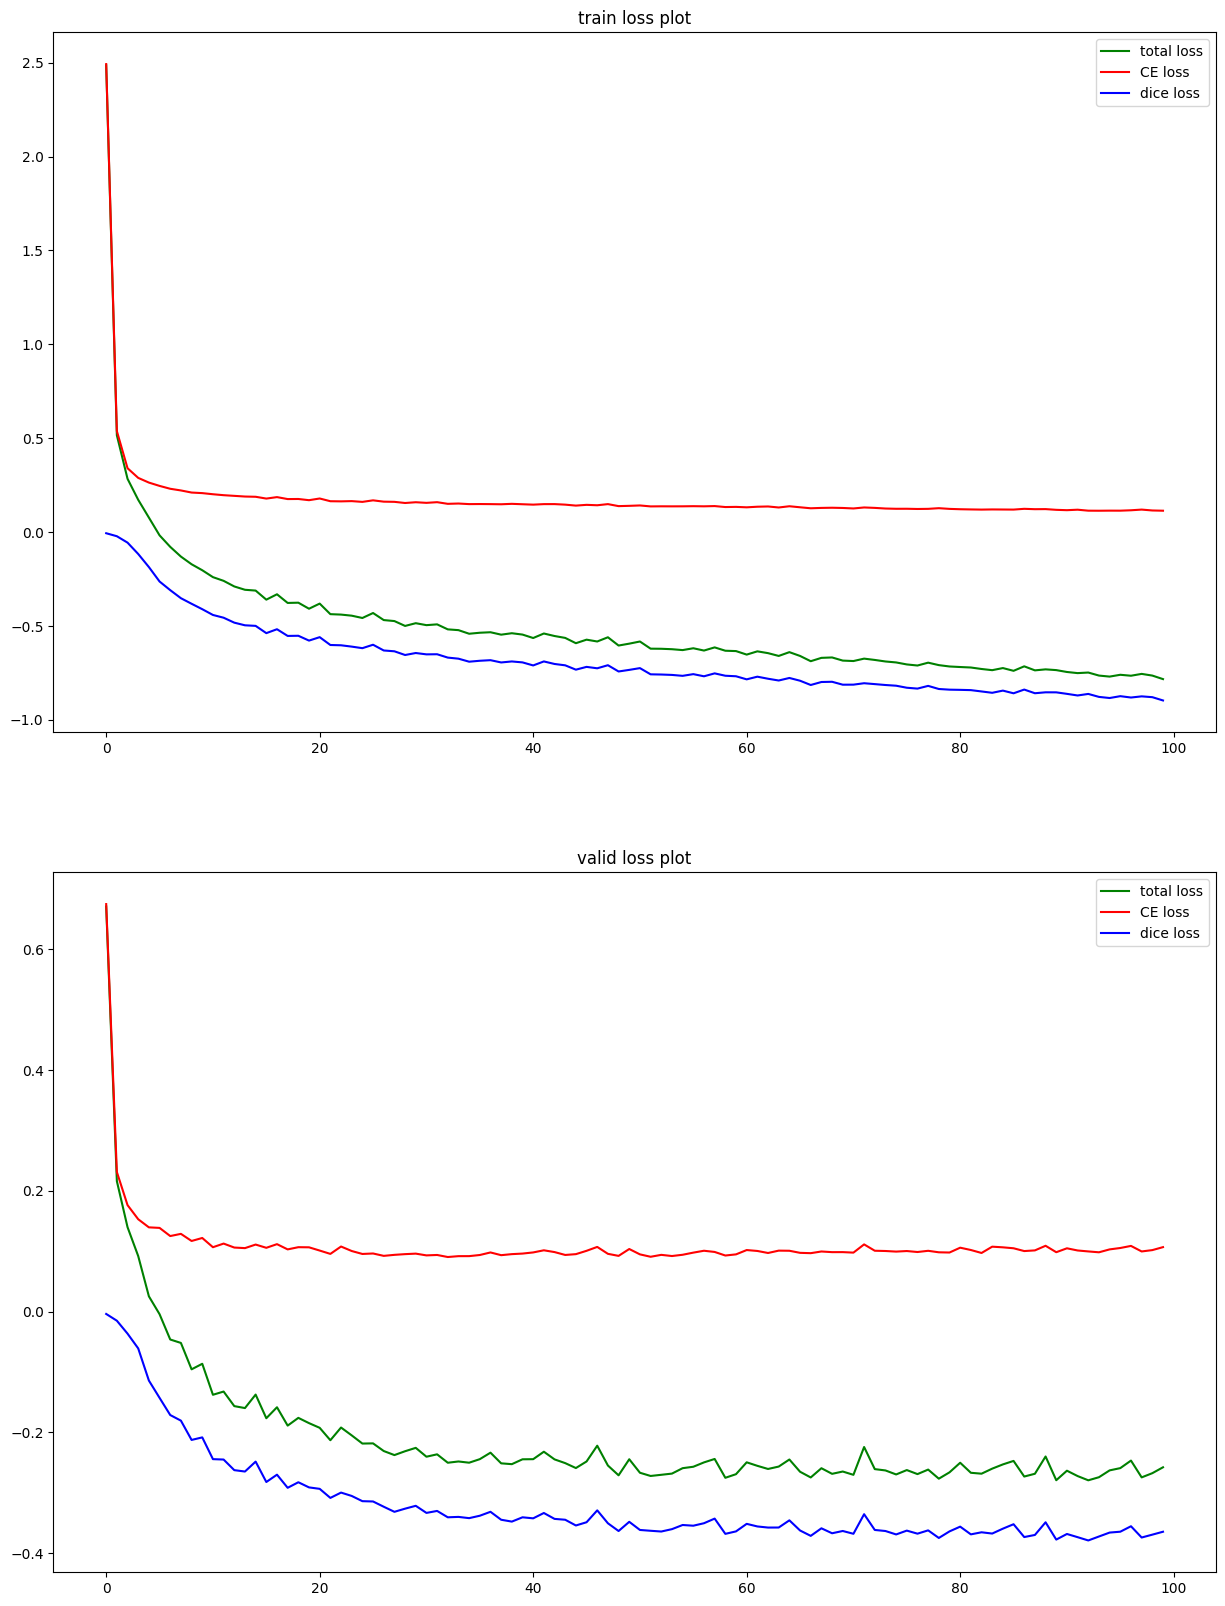

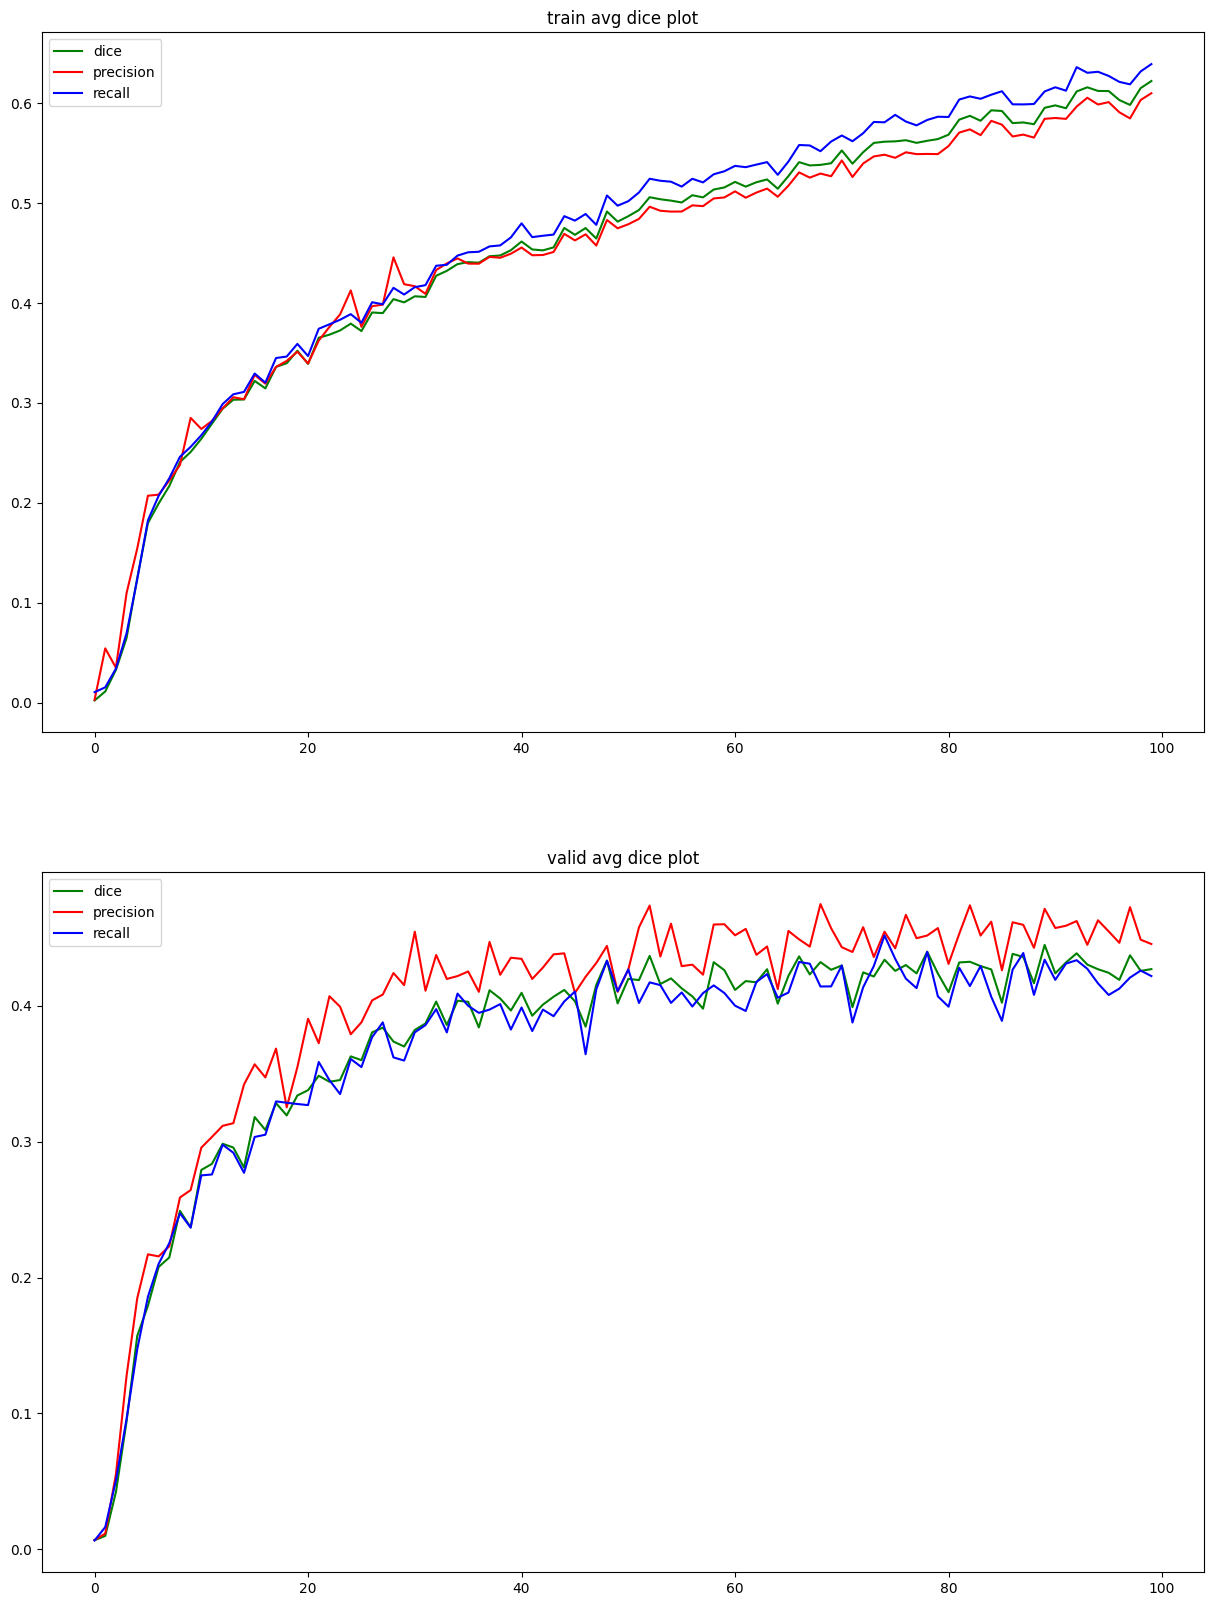

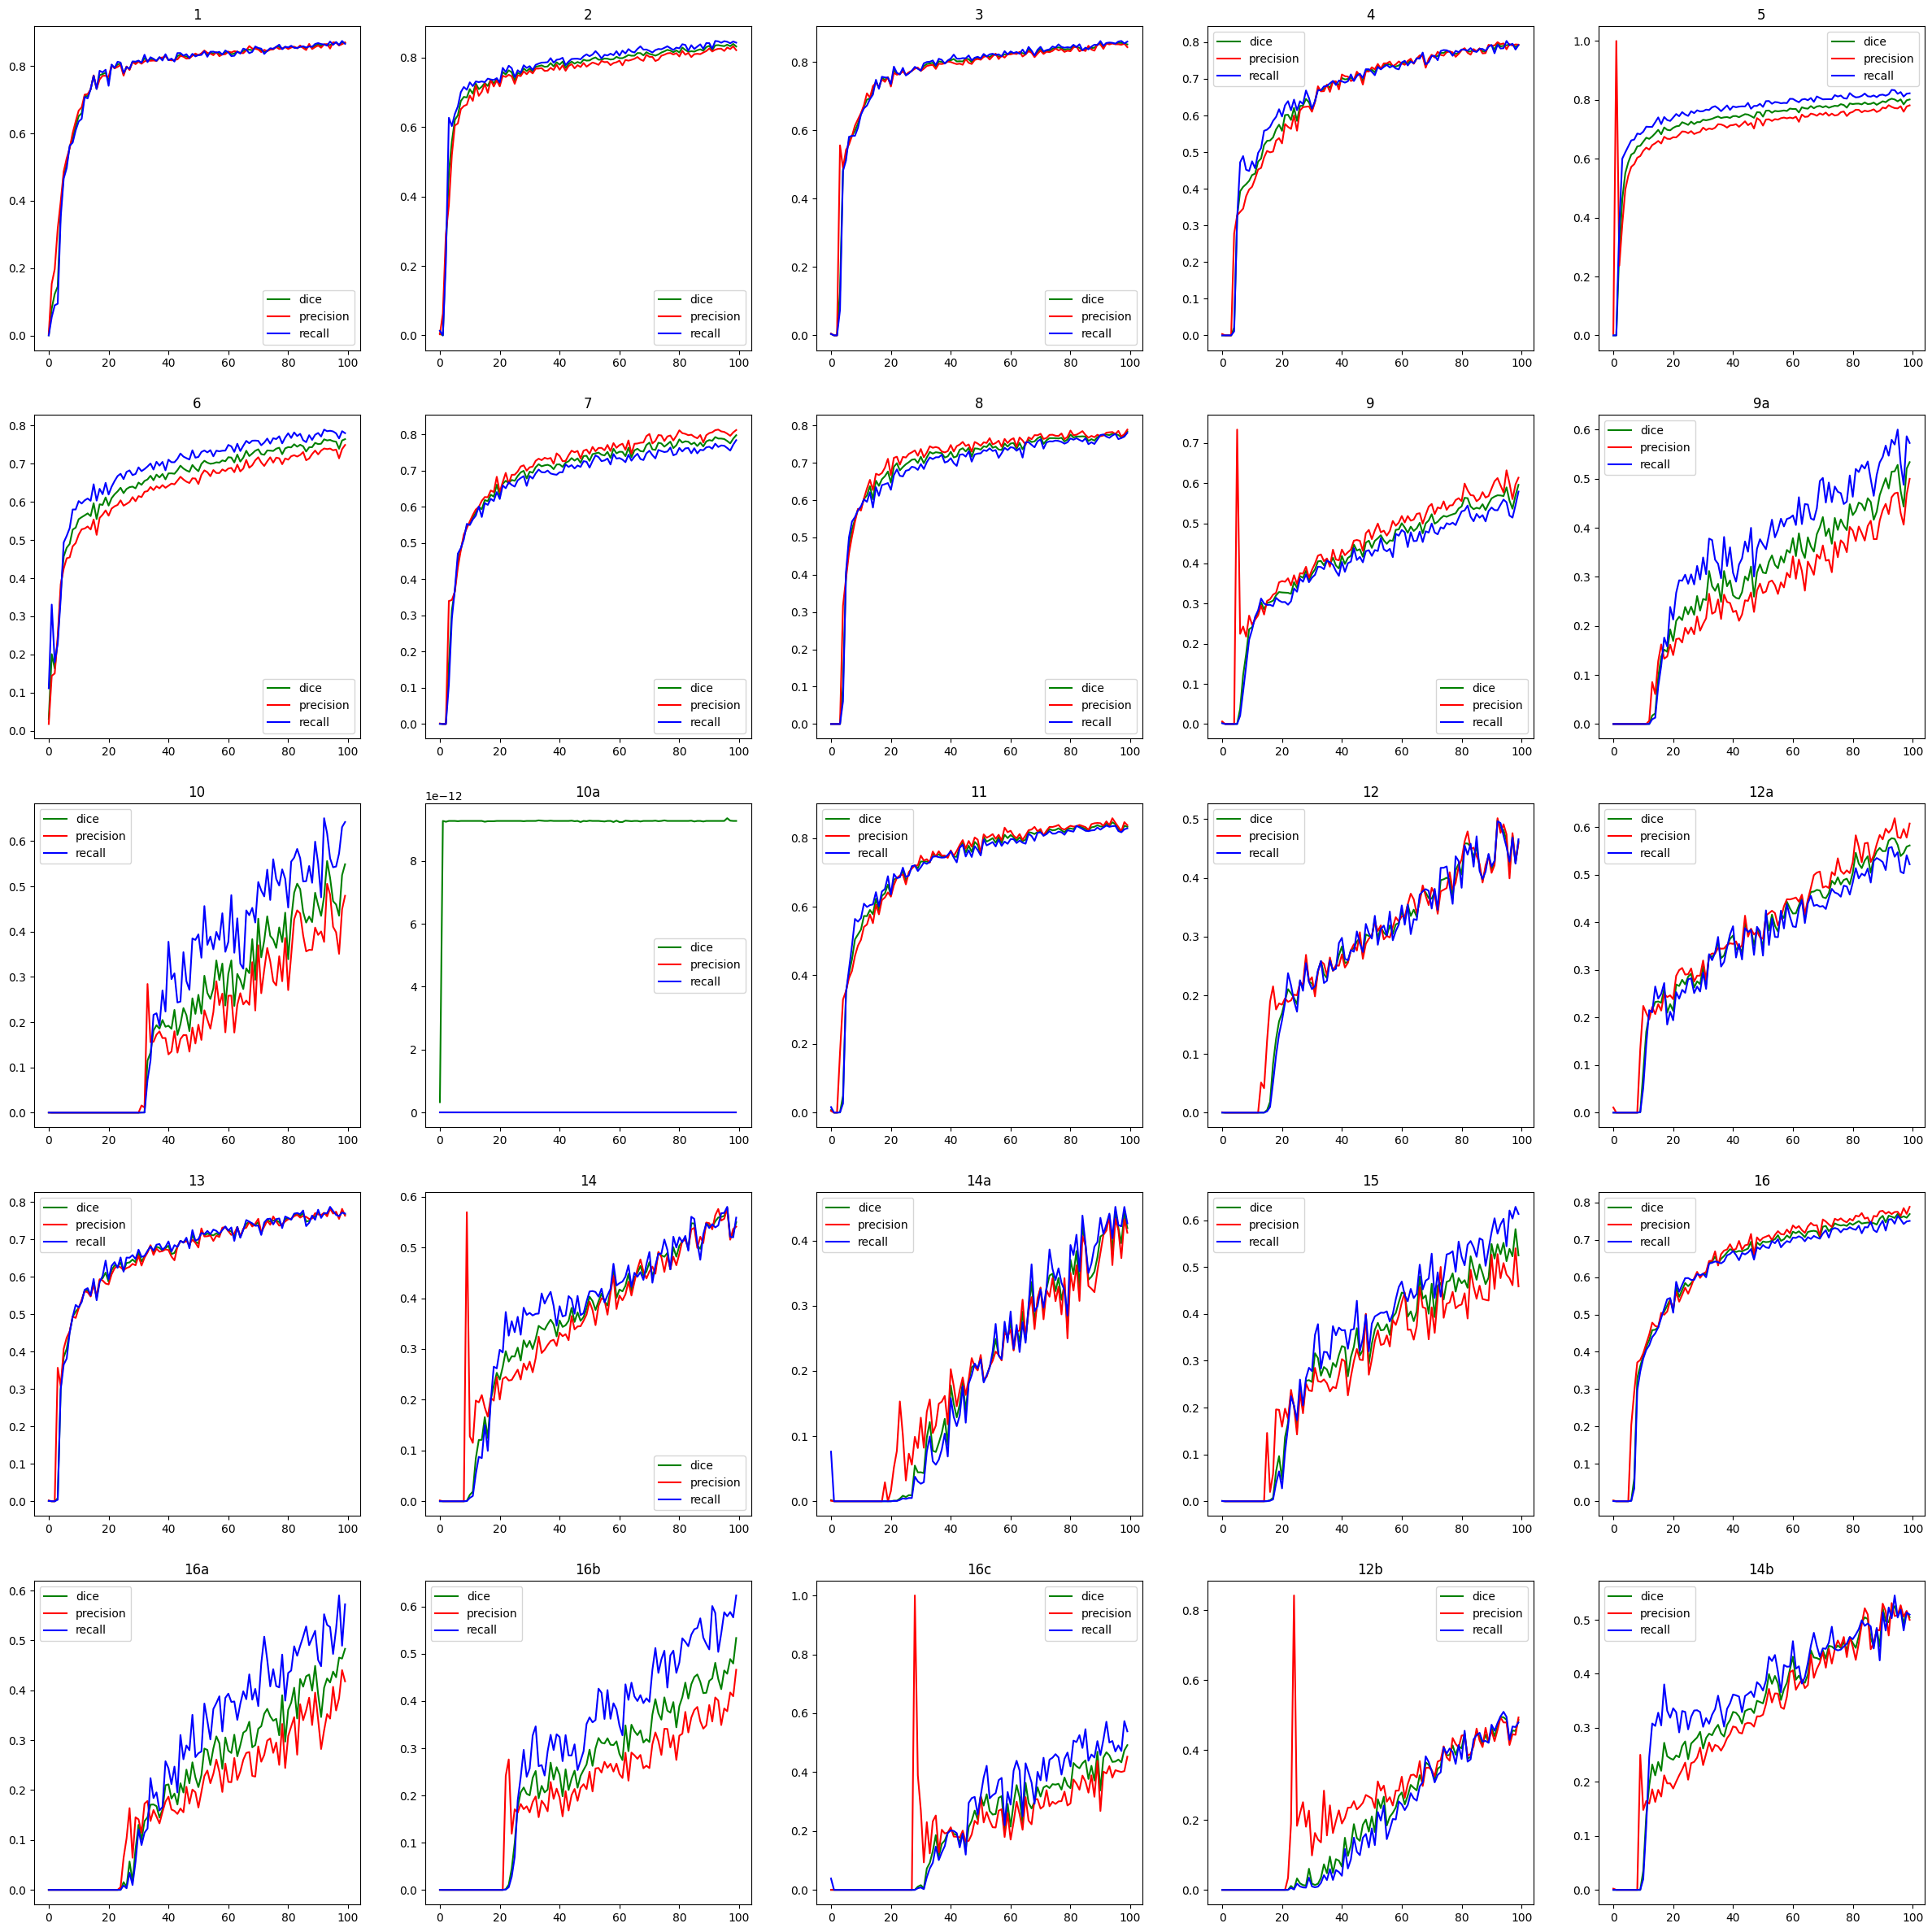

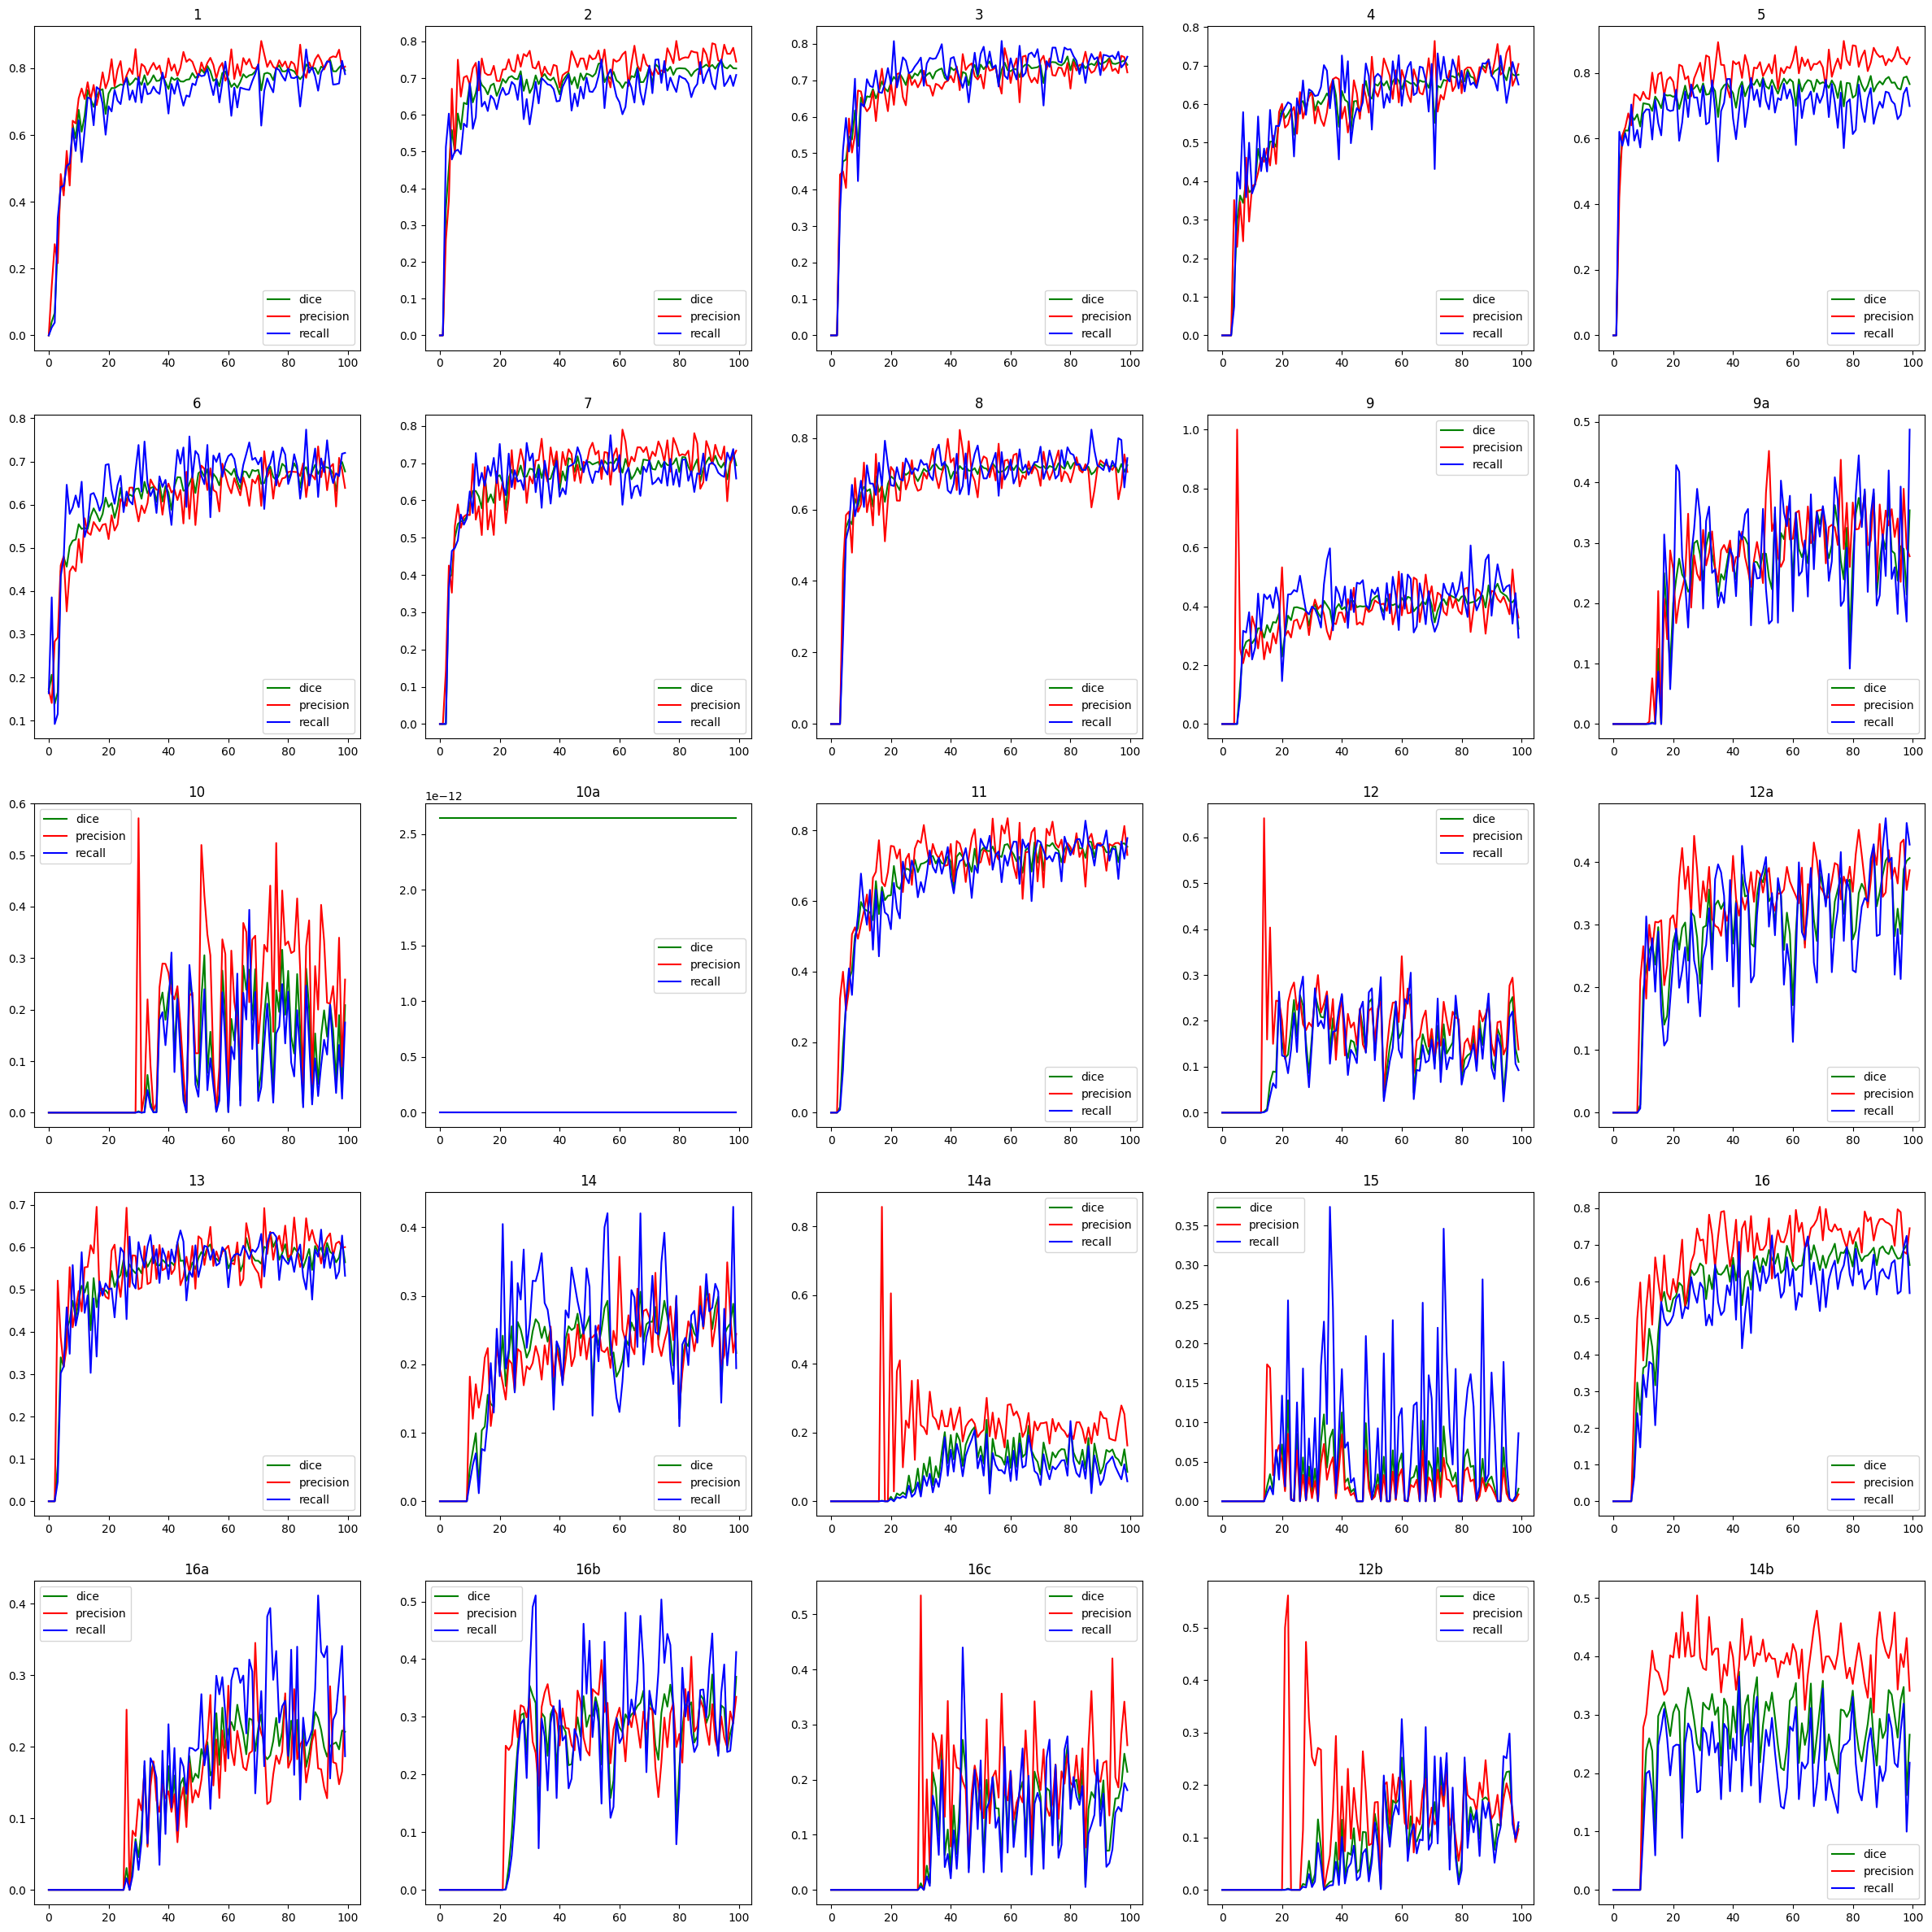

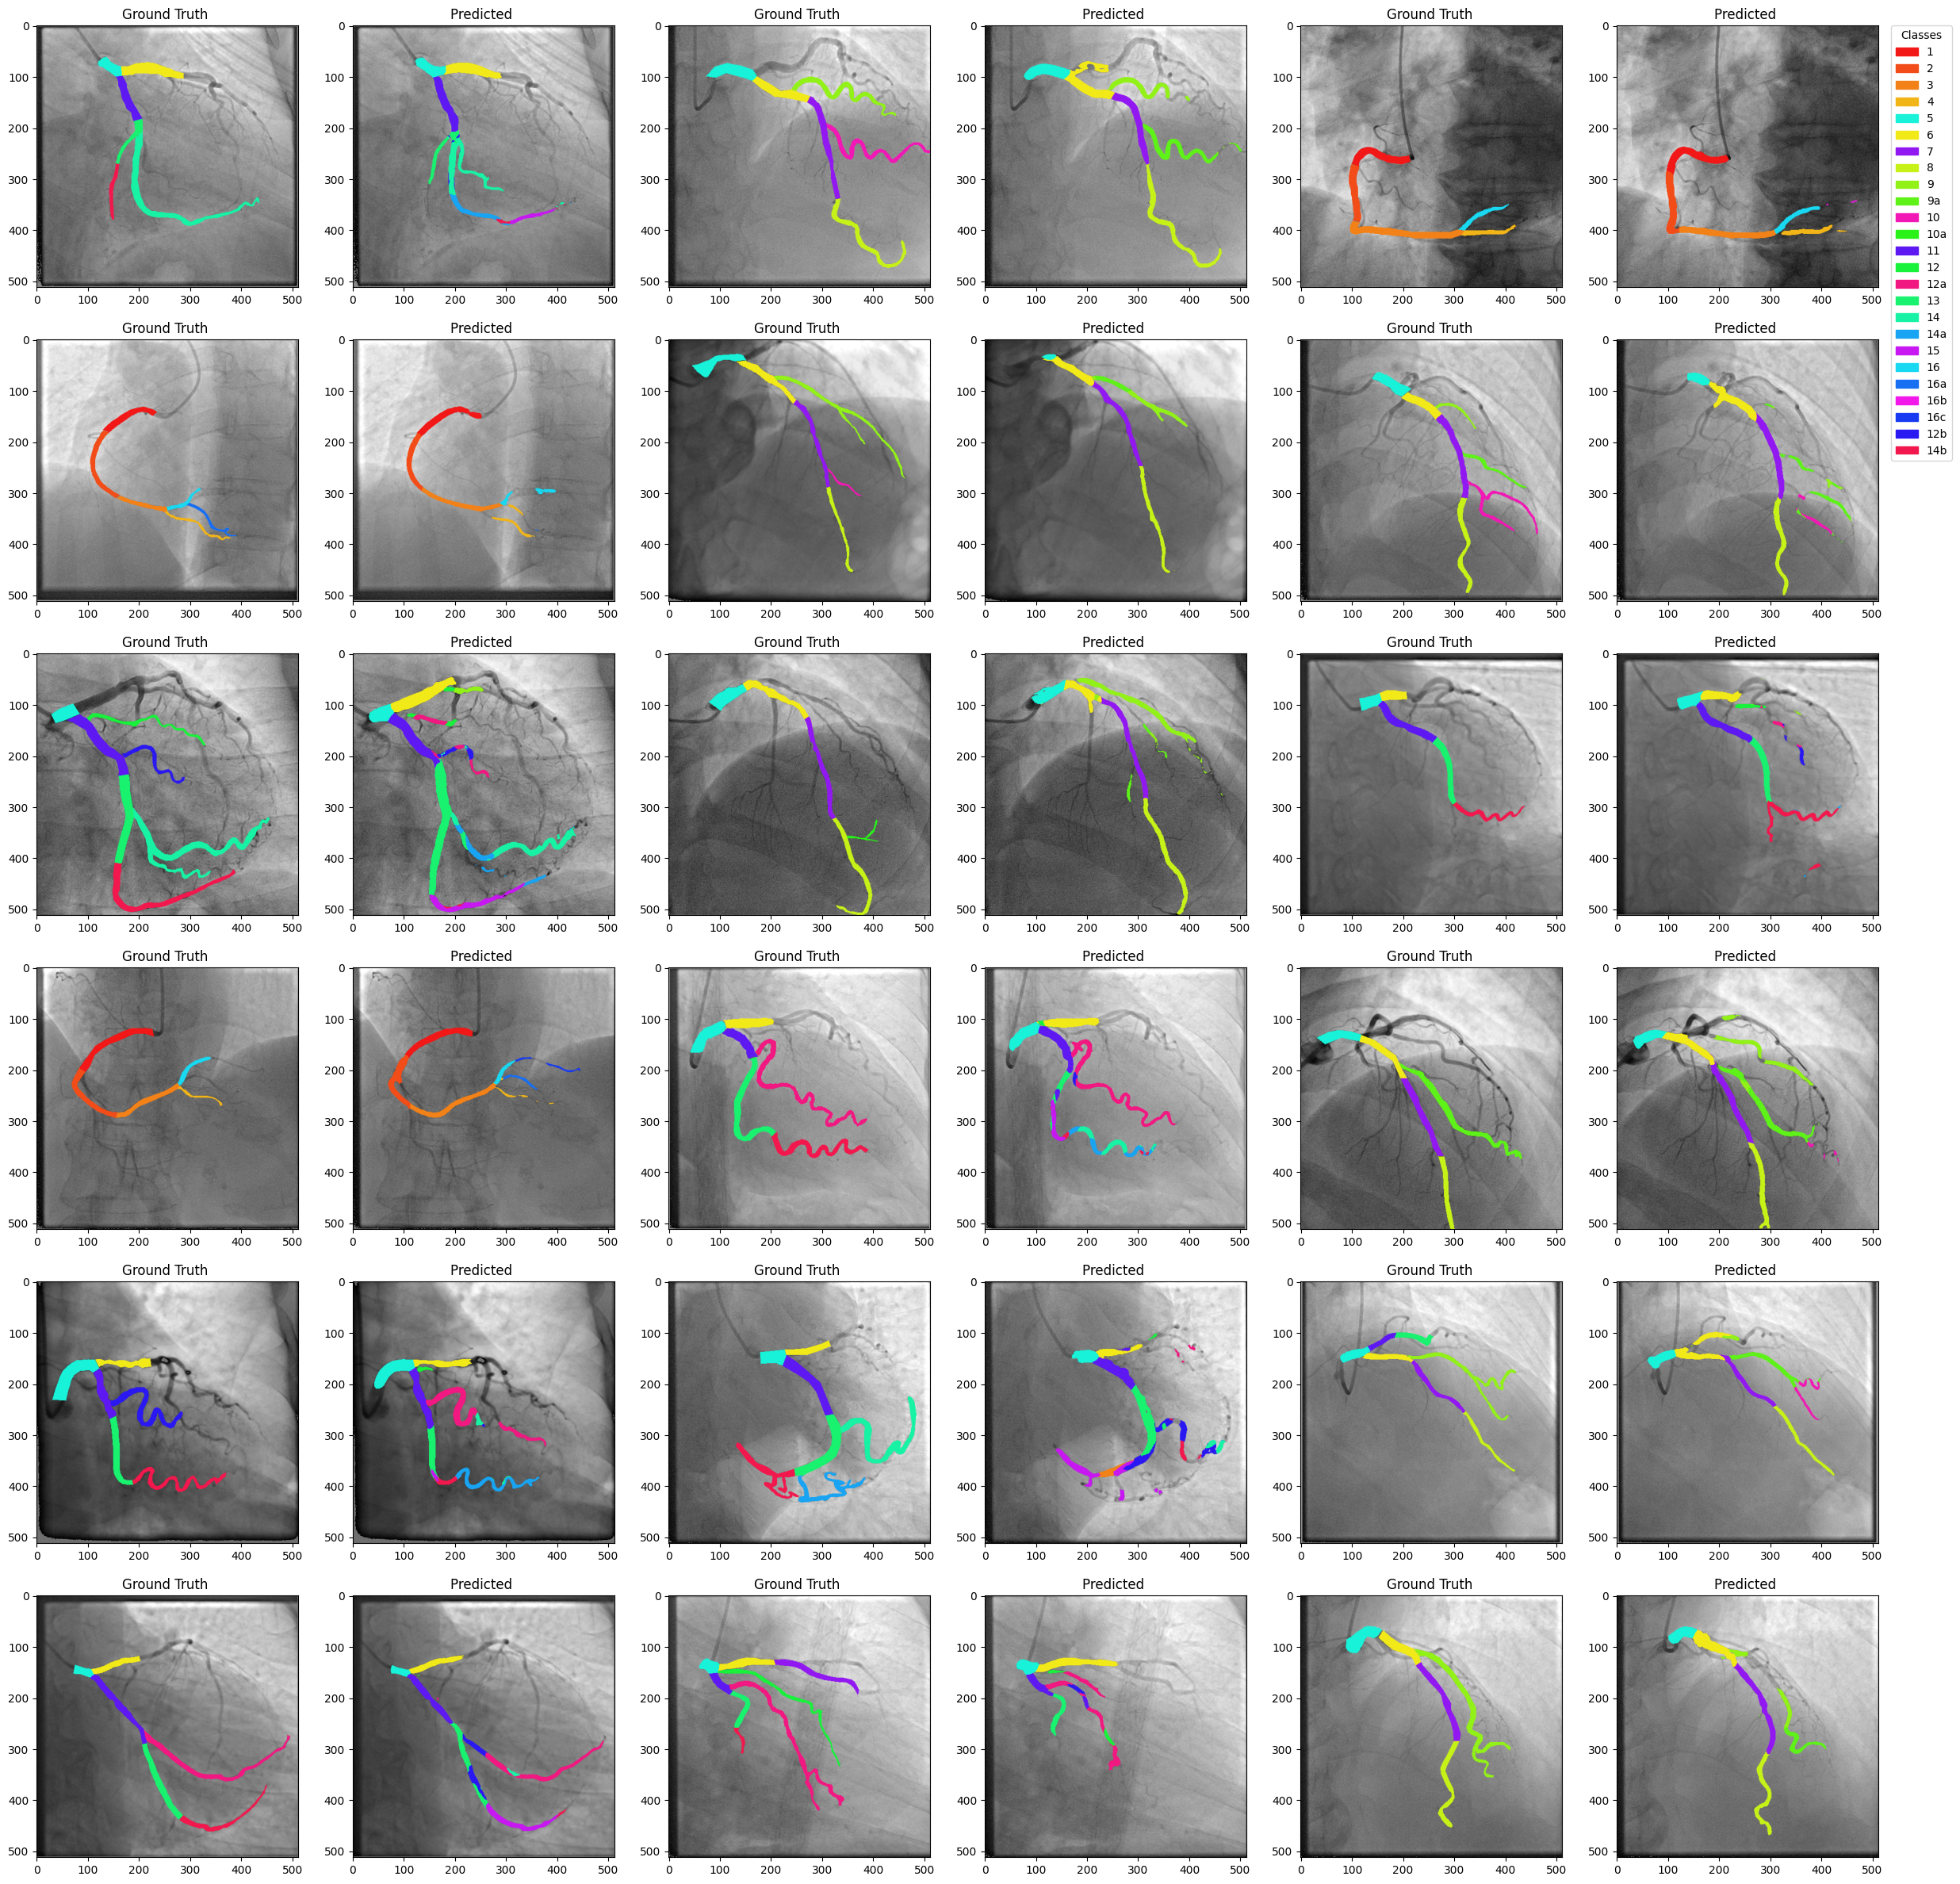

In [11]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)